In [2]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/abparam16_delgau1.5_1525.txt')

In [249]:
pdfout.columns

ColDefs(
    name = 'OBJ'; format = '18A'
    name = 'AGE'; format = '71D'
    name = 'MASS'; format = '652D'
    name = 'LOGG'; format = '143D'
    name = 'P'; format = '71D'
    name = 'P2'; format = '71D'
    name = 'P3'; format = '71D'
    name = 'P4'; format = '71D'
    name = 'P_MEAN'; format = 'E'
    name = 'P2_MEAN'; format = 'E'
    name = 'P3_MEAN'; format = 'E'
    name = 'P4_MEAN'; format = 'E'
    name = 'P_VAR'; format = 'E'
    name = 'P2_VAR'; format = 'E'
    name = 'P3_VAR'; format = 'E'
    name = 'P4_VAR'; format = 'E'
    name = 'PMASS'; format = '652D'
    name = 'PLOGG'; format = '143D'
)

In [167]:
len(clndr16)

2427

Labels for PARSEC isochrones

0 = PMS, pre main sequence

1 = MS, main sequence

2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars

3 = RGB, red giant branch, or the quick stage of red giant for intermediate+massive stars

4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars

5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars

6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars

7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for massive stars

8 = TPAGB, the thermally pulsing asymptotic giant branch

9 = post-AGB (in preparation!)

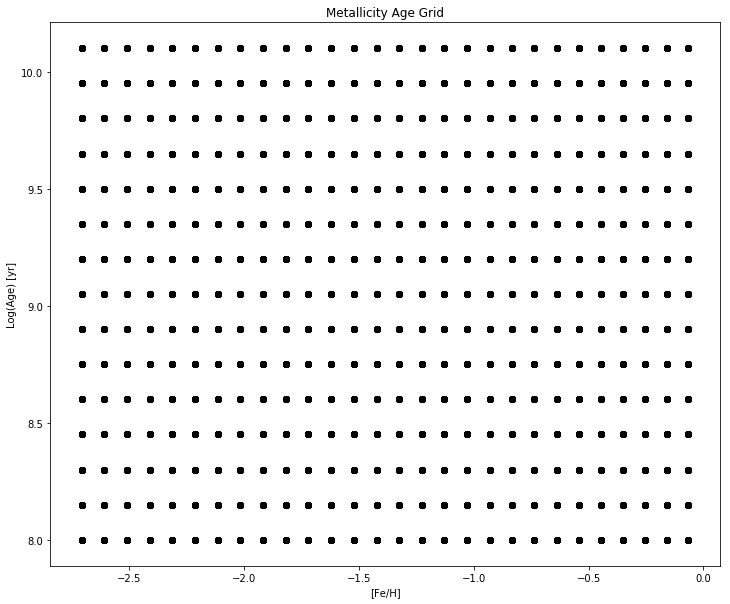

In [3]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(np.log10(parsec['Zini']/0.02),parsec['logAge'],c='k',cmap='jet')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('PARSECgrid.pdf',bbox_inches='tight')
plt.show()

In [4]:
import itertools as it

y1 = parsec['logTe']
y2 = parsec['Ksmag']
y3 = np.log10(parsec['Zini']/0.02)
y4  = parsec['logg']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

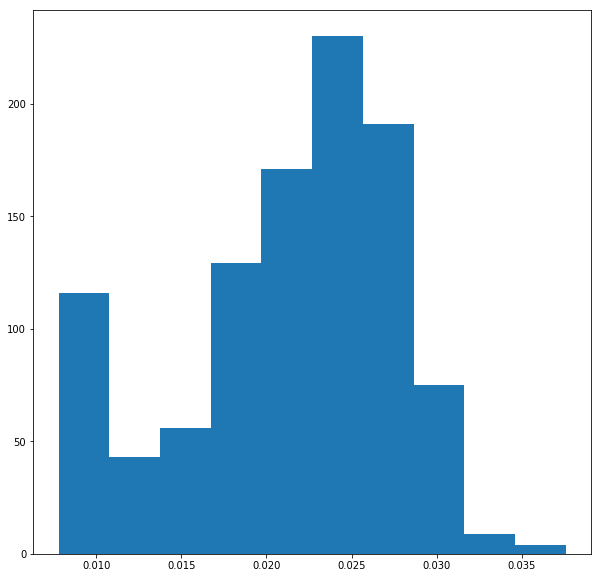

0.007780979977408009
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y23', 'y24', 'y34', 'y2sq',
       'y3sq', 'y4sq'], dtype='<U4')]
[array([ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,
       -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,
       -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,
        6.19034227e-01])]


In [5]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

In [6]:
small = np.where(np.asarray(model_mads)<=0.01)

terms = []
for i in range(len(models_str_good[small])):
    terms.append(len(models_str_good[small][i]))
    
print(terms)
# print(models_str_good[small][0])

parsimonious = np.array([y1,y2,y3,y4,y12,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y34,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y1sq,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y23,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y24,y34,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))
print('mad',mad(parsimonious_residual))

parsimonious = np.array([y1,y2,y3,y4,y24,y1sq,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.825e+06
Date:                Fri, 23 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:48:58   Log-Likelihood:                 46192.
No. Observations:               16121   AIC:                        -9.236e+04
Df Residuals:                   16111   BIC:                        -

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.168e+06
Date:                Fri, 23 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:48:58   Log-Likelihood:                 44058.
No. Observations:               16121   AIC:                        -8.810e+04
Df Residuals:                   16111   BIC:                        -8.802e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9917      0.183     92.633      0.0

In [3]:
##########################
### Define Model Above ###
##########################

# def parfit(x1,x2,x3,x4):
#     p = [ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,\
#        -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,\
#        -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,\
#         6.19034227e-01]
#     return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
# p[7]*np.multiply(x2,x3)+p[8]*np.multiply(x2,x4)+p[9]*np.multiply(x3,x4)+p[10]*(x2**2)+p[11]*(x3**2)+p[12]*\
#(x4**2)

def parfit(x1,x2,x3,x4):
    p = [19.57711154,  1.62799079,  4.41723963,  0.24957004, -7.04845086, -0.39628751,\
 -0.5399325,   0.11835753,  0.05859978,  0.63493432]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x2,x4)+\
p[7]*(x2**2)+p[8]*(x3**2)+p[9]*(x4**2)

In [4]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])

In [5]:
sol_xm[1]

0.06901474154376043

In [6]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [7]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
#     am = clndr16['ALPHA_M'][i]
#     amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parfit(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

KeyboardInterrupt: 

In [ ]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(parage,devs,c='k',marker='+',label='Polynomial')
#plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Bayesian')
plt.xlim(7,13)
#plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.1,0.5)
plt.title(r'PARSEC Uncertainty vs Age')
#plt.legend()
plt.savefig('parsec_uncert_age.pdf',bbox_inches='tight')
plt.show()

ValueError: x and y must be the same size

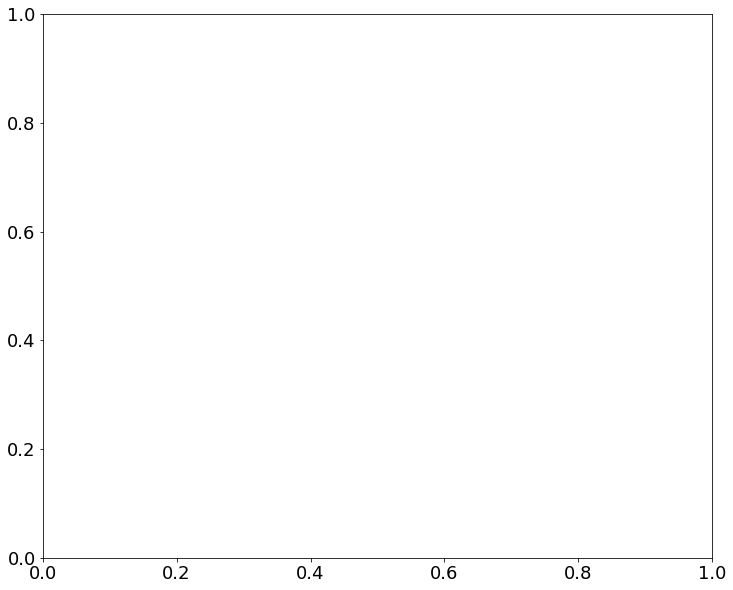

In [128]:
#lowgrav = np.where(clndr16['LOGG']<0.20)
plt.figure(figsize=[12,10])
#plt.scatter(parage[lowgrav],clnpdfout['P_MEAN'][lowgrav],c=clndr16['LOGG'][lowgrav],marker='+',\
            #cmap='nipy_spectral')
plt.scatter(parage,clnpdfout['P_MEAN'],c=clndr16['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='k')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
#plt.axvline(10.13,c='r')
#plt.axvline(10.13+max(devs),c='r',linestyle='--')
plt.xlabel(r'Polynomial Ages Log(Age) [yr]')
plt.ylabel(r'Bayesian Ages Log(Age) [yr]')
plt.title(r'PARSEC Age to Age with Color as Log(g)')
plt.savefig('parsec_age_age.pdf',bbox_inches='tight')
plt.show()

In [10]:
print(ageU)

13208053784.589062


In [ ]:
#######################
### Age vs Position ###
#######################

zero = np.where(clnpdfout['P_MEAN']>=0)
young = np.where(parage<=10.13+max(devs))

plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'][young],clndr16['DEC'][young],c=parage[young],marker='+',cmap='seismic')
# plt.scatter(clndr16['RA'][zero],clndr16['DEC'][zero],c=clnpdfout['P_MEAN'][zero],marker='+',cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()
plt.title(r'Color as Log(Age) [Gyr]')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()


In [ ]:
#######################
### Distance vs Age ###
#######################

plt.figure(figsize=[10,10])
#plt.scatter(stardist[zero],clnpdfout['P_MEAN'][zero],marker='+',c='k')
plt.scatter(stardist[young],parage[young],marker='+',c='k')
plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Age')
plt.show()


In [ ]:
################
### Abudance ###
################

plt.figure(figsize=[10,10])
plt.scatter(clndr16['C_FE'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[C/Fe]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [C/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['N_FE'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[N/Fe]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [N/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['FE_H'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [Fe/H]')
plt.show()

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['C_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[C/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['N_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[N/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['O_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[O/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()


In [ ]:
##################
### Kinematics ###
##################

plt.figure(figsize=[10,10])
plt.scatter(clndr16['RV_AUTOFWHM'][young],parage[young],marker='+',c='k')
plt.xlabel(r'vsini [km/s]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of Radial Velocity')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['GAIA_PMML'][young],clndr16['GAIA_PMMB'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'$\mu_{Mlon}$')
plt.ylabel(r'$\mu_{Mlat}$')
plt.title(r'Proper Motion Space with Color as Age')
plt.show()

In [9]:
###############
### SNR Cut ###
###############

parage = parfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])

cut = np.where(clndr16['SNR']>80)
dr16snr = clndr16[cut]
uage = np.where(parage[cut]<10.13)

In [ ]:
chrisage = 12990000000.0-(10**6)*Chrismod['Time']
print(max(chrisage))
print(ageU/10**11)
#print(12*10**11-chrisage)

In [ ]:
#########################
### Age and Abundance ###
#########################

import scipy.stats as st

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['C_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['C_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CFe'],c='k',label='Evolution Model')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.2)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_c.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['N_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['N_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NFe'],c='k',label='Evolution Model')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.5,1.0)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_n.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['O_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['O_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['OFe'],c='k',label='Evolution Model')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.25,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_o.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['NA_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['NA_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1.0,1.0)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_na.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['MG_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['MG_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['MgFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.2,0.5)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_mg.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['AL_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['AL_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['AlFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_al.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['SI_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['SI_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['SiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.25,0.25)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_si.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['KFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[K/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,1.0)
# #plt.xscale('log')
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_k.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['CA_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['CA_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.375,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_ca.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['CR_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['CR_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CrFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.75)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_cr.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['MnFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Mn/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,0.125)
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_mn.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['CO_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['CO_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.5)
#plt.xscale('log')
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_co.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['NI_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['NI_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.375,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_ni.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**parage[cut][uage]/10**9,dr16snr['FE_H'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[cut][uage]/10**9,dr16snr['FE_H'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['FeH'],c='k',label='Evolution Model')
plt.ylabel(r'[Fe/H]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-2.5,-0.25)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_fe.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut],dr16snr['CU_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
# plt.plot(chrisage,Chrismod['CuFe'],c='k')
# plt.ylabel(r'[Cu/Fe]')
# plt.xlabel(r'Age')
# plt.ylim(-0.75,1)
# plt.xscale('log')
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.savefig('parsec_age_cu.pdf',bbox_inches='tight')
# plt.show()

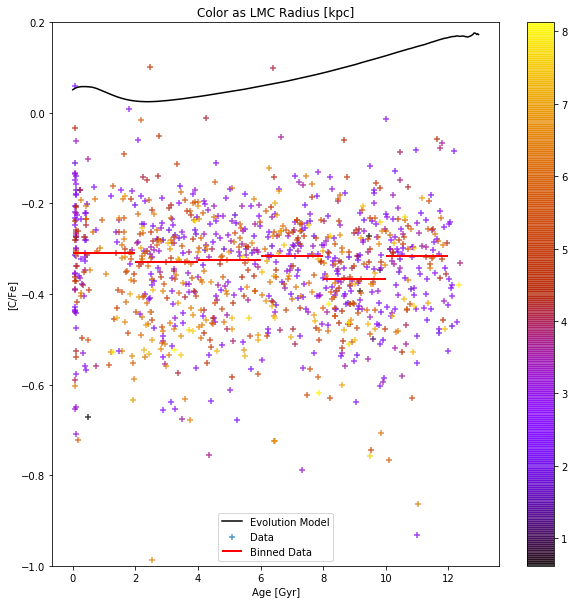

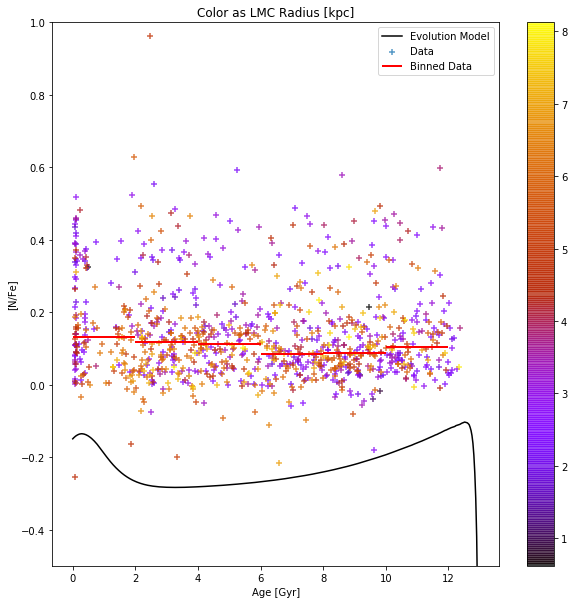

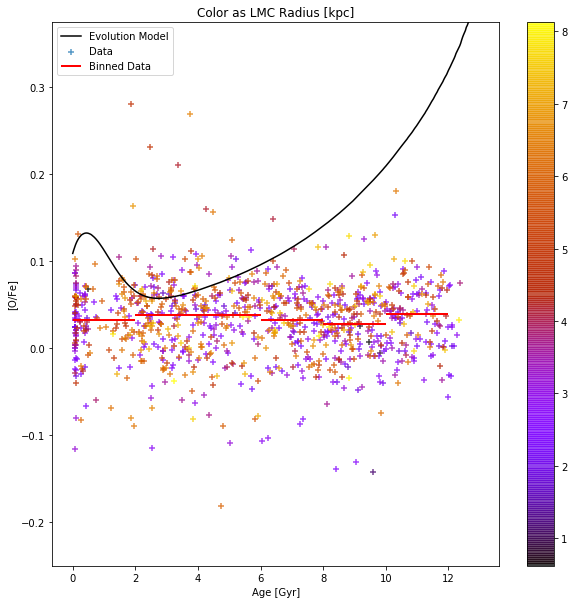

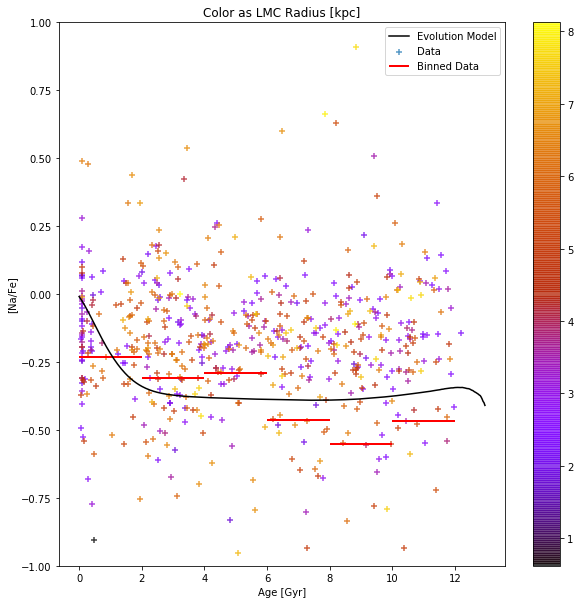

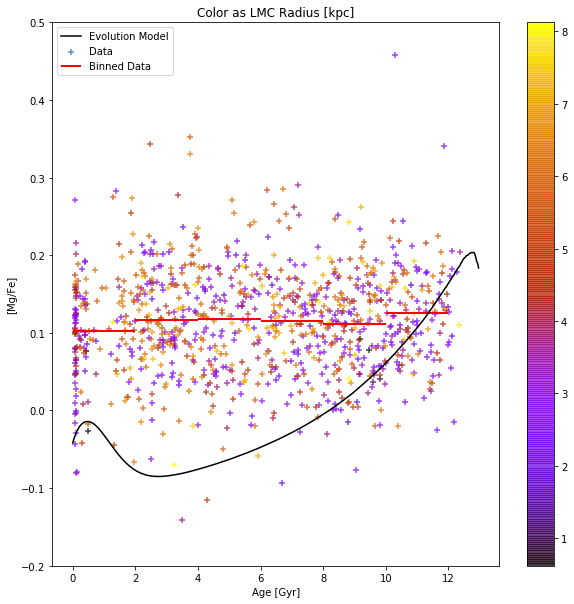

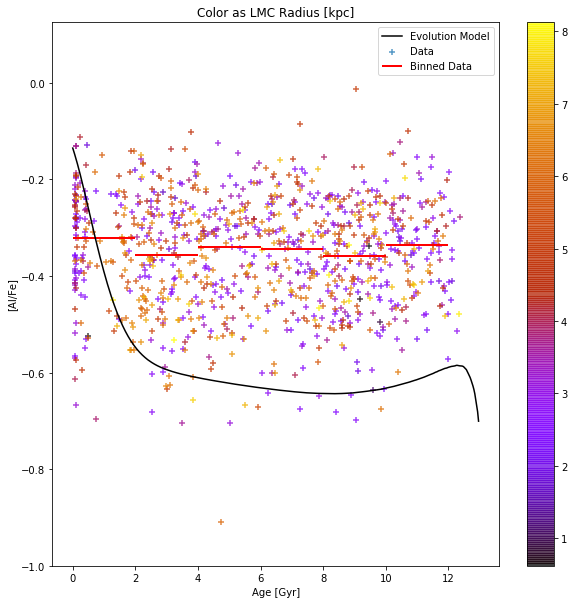

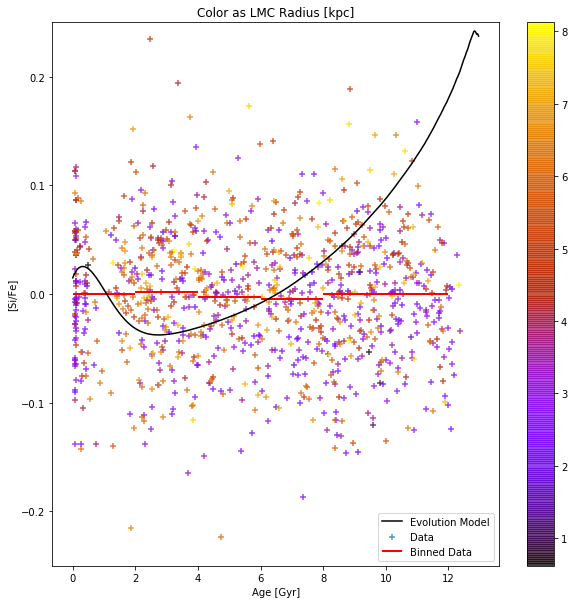

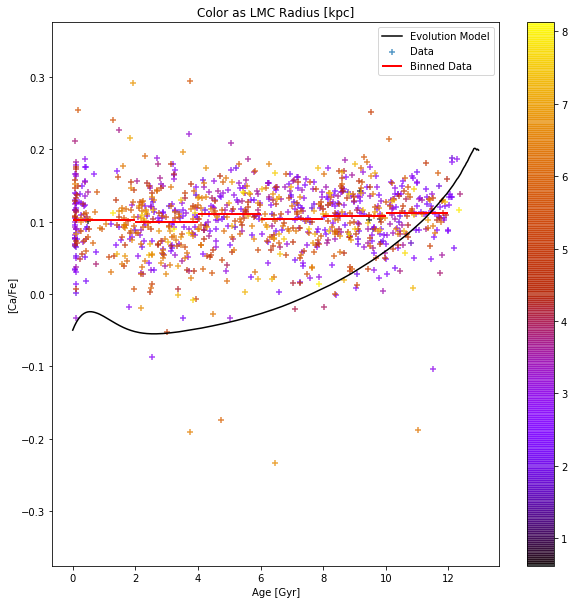

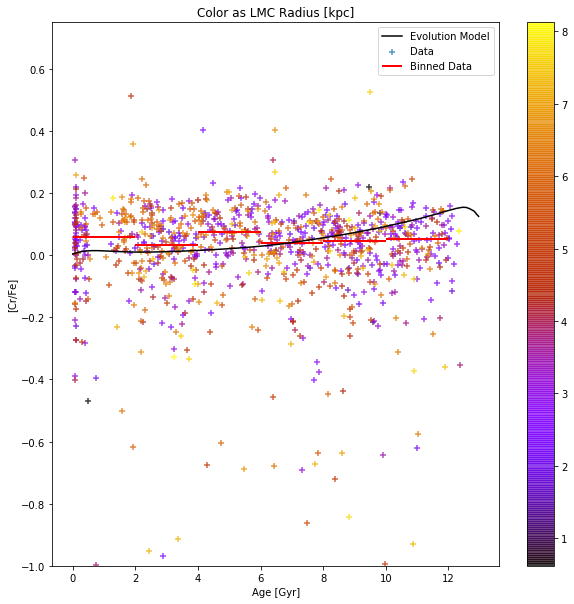

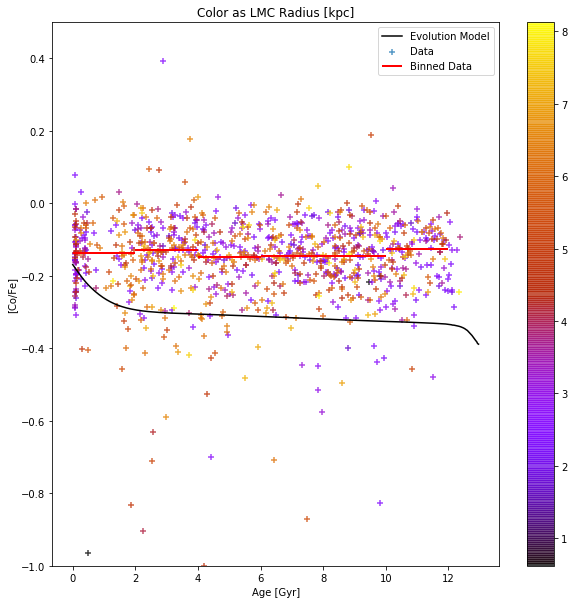

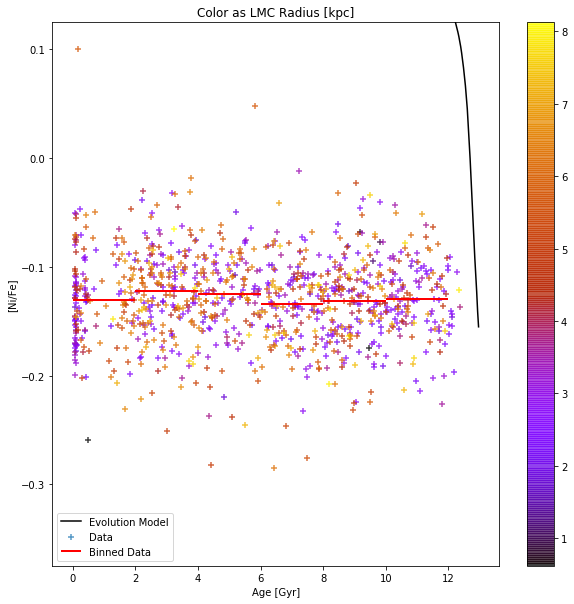

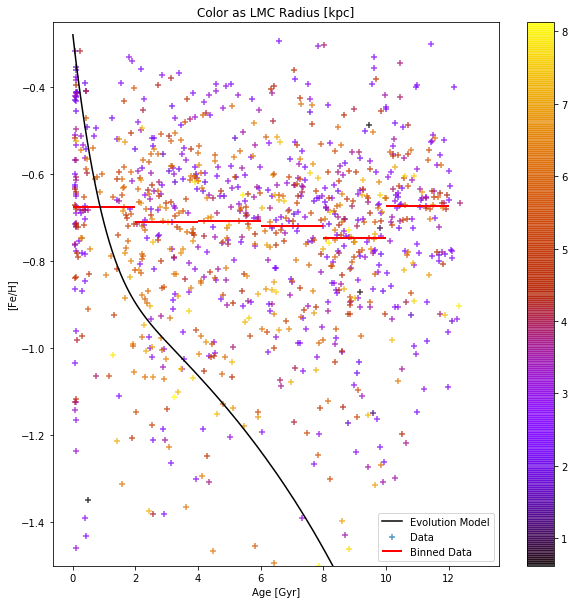

In [116]:
plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['C_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['C_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CFe'],c='k',label='Evolution Model')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.2)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_c_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['N_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['N_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NFe'],c='k',label='Evolution Model')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.5,1.0)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_n_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['O_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['O_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['OFe'],c='k',label='Evolution Model')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.25,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_o_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['NA_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['NA_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1.0,1.0)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_na_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['MG_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['MG_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['MgFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.2,0.5)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_mg_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['AL_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['AL_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['AlFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_al_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['SI_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['SI_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['SiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.25,0.25)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_si_diane.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['KFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[K/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,1.0)
# #plt.xscale('log')
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_k_diane.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CA_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CA_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.375,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_ca_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CR_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CR_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CrFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.75)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_cr_diane.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['MnFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Mn/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,0.125)
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_mn_diane.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CO_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['CO_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1,0.5)
#plt.xscale('log')
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_co_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['NI_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['NI_FE'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['NiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.375,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_ni_diane.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['FE_H'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data')
bin_means, bin_edges, binnumber = st.binned_statistic(10**clnpdfout['P_MEAN'][cut]/10**9,dr16snr['FE_H'], statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
plt.plot(chrisage/10**9,Chrismod['FeH'],c='k',label='Evolution Model')
plt.ylabel(r'[Fe/H]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-1.5,-0.25)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_fe_diane.jpg',bbox_inches='tight')
plt.show()

In [110]:
print(clnpdfout['P_MEAN'])

[ 9.602124  9.982274 10.060365 ... 10.01539   9.467867  9.569907]


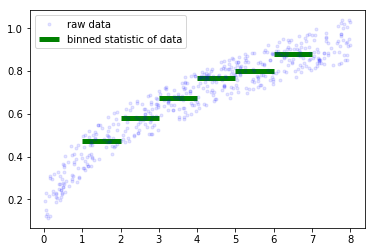

In [93]:
import scipy.stats as ss
windspeed = 8 * np.random.rand(500)
boatspeed = .3 * windspeed**.5 + .2 * np.random.rand(500)
bin_means, bin_edges, binnumber = ss.binned_statistic(windspeed,boatspeed, statistic='median', bins=[1,2,3,4,5,6,7])
plt.figure()
plt.plot(windspeed, boatspeed, 'b.', label='raw data',alpha=0.1)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5,label='binned statistic of data')
plt.legend()

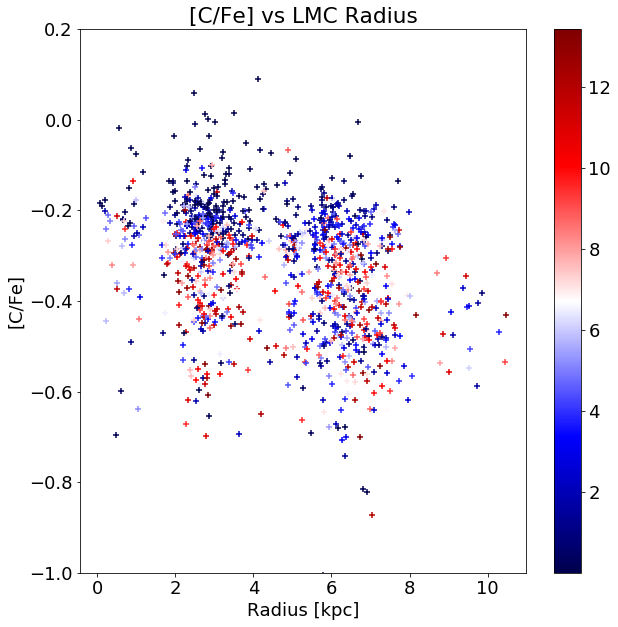

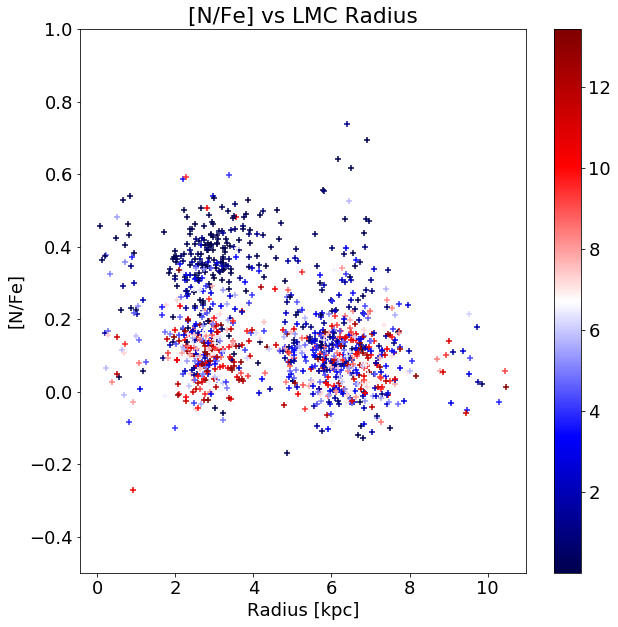

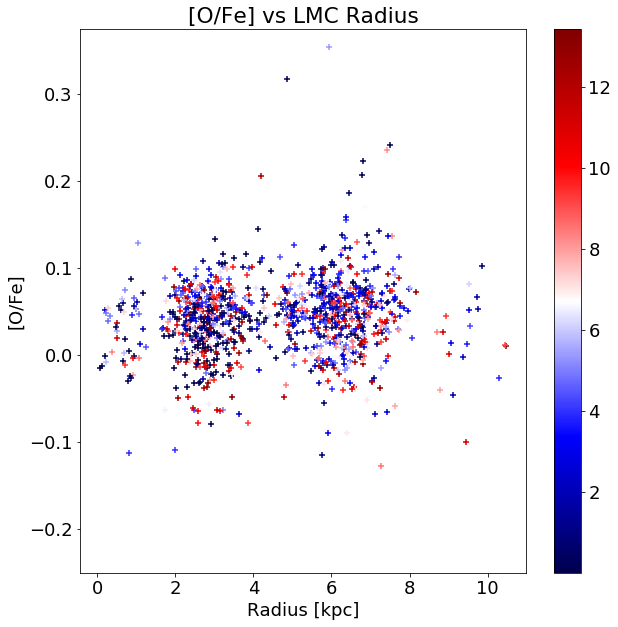

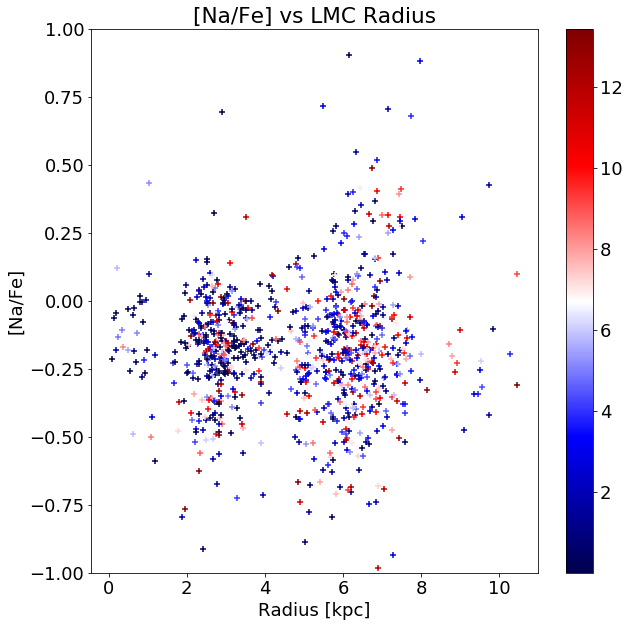

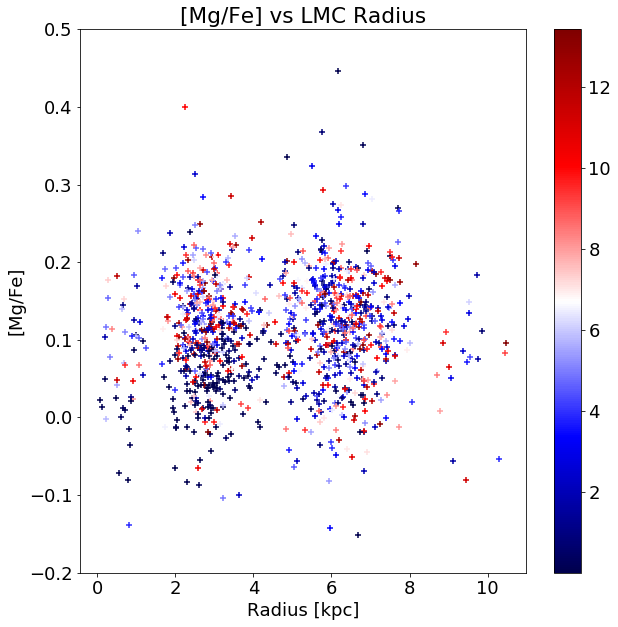

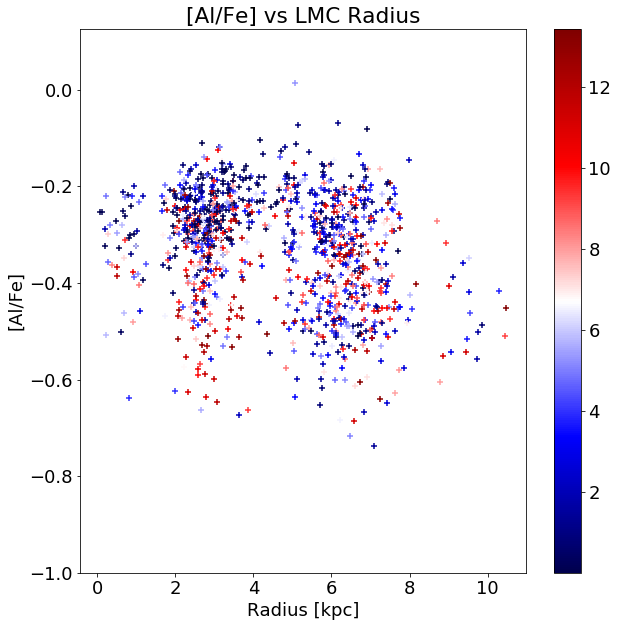

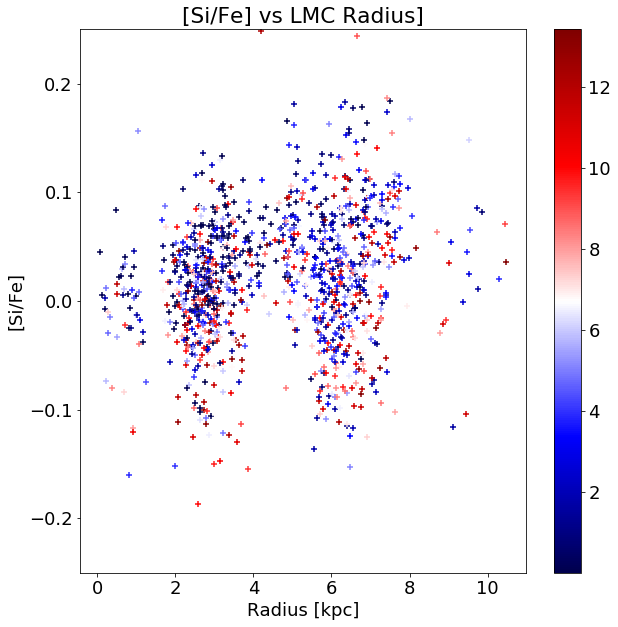

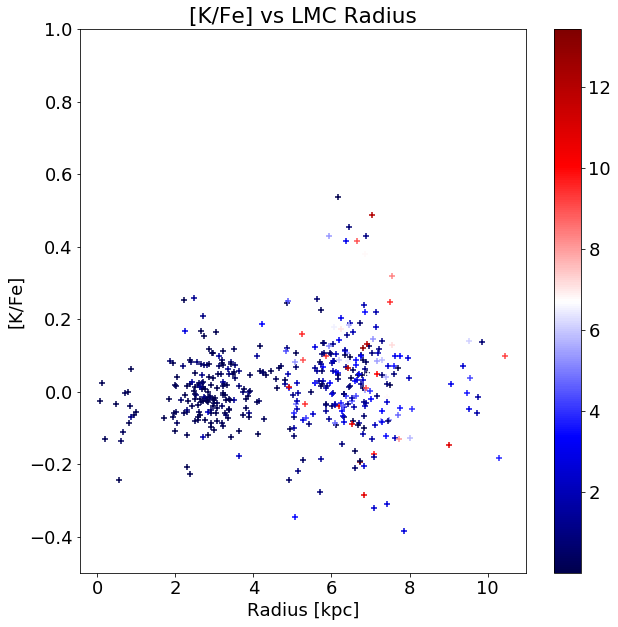

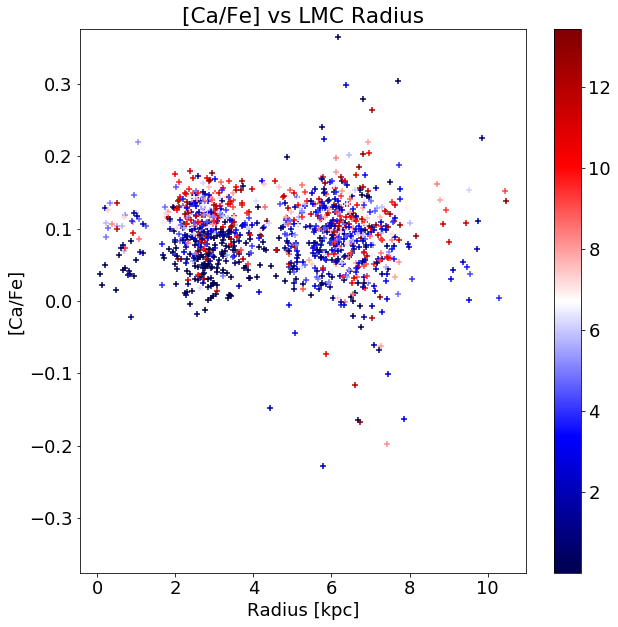

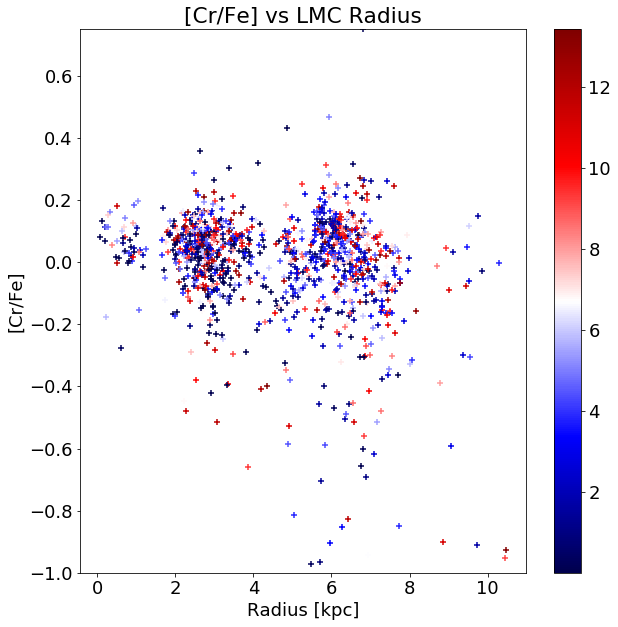

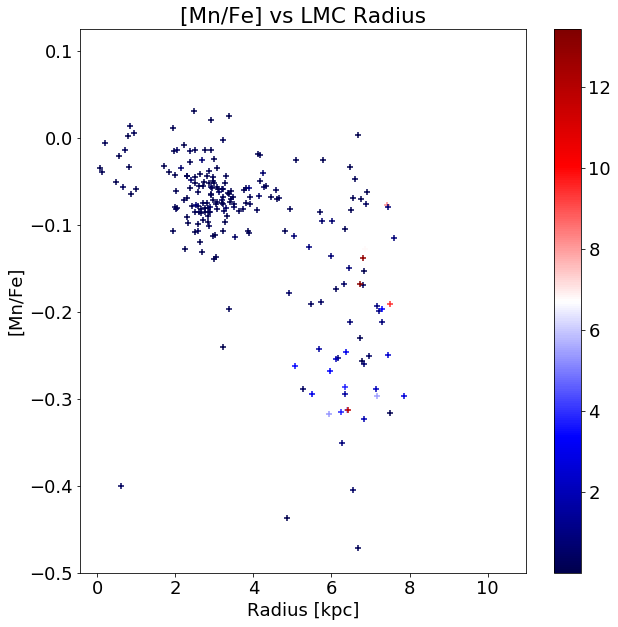

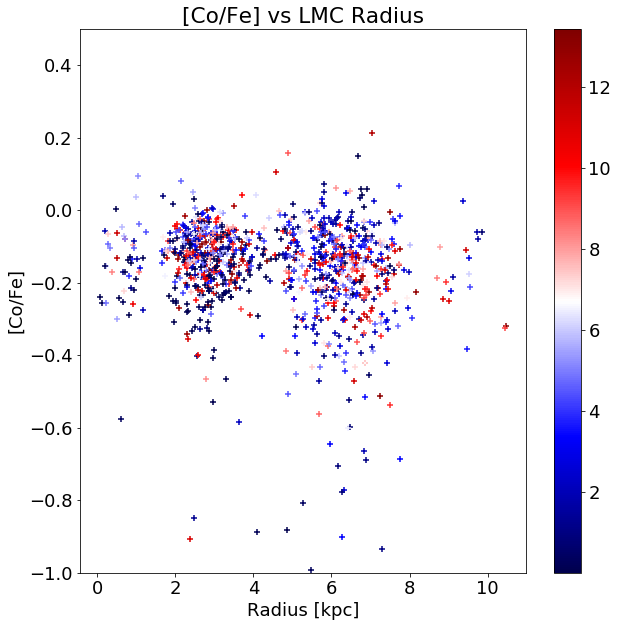

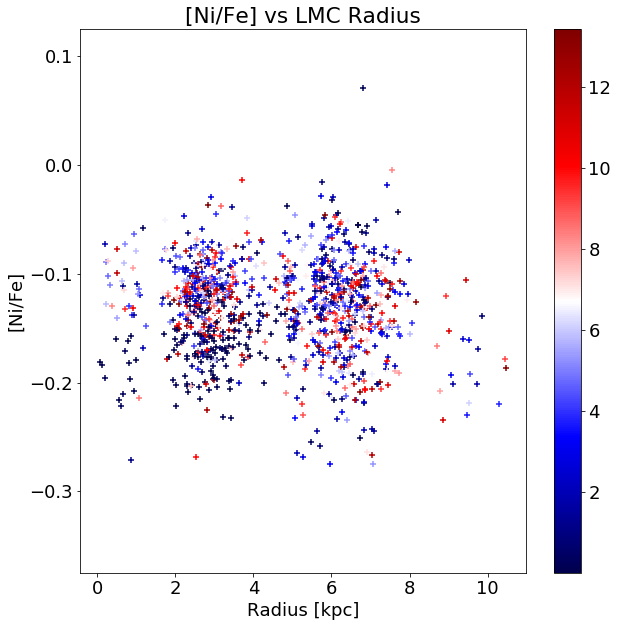

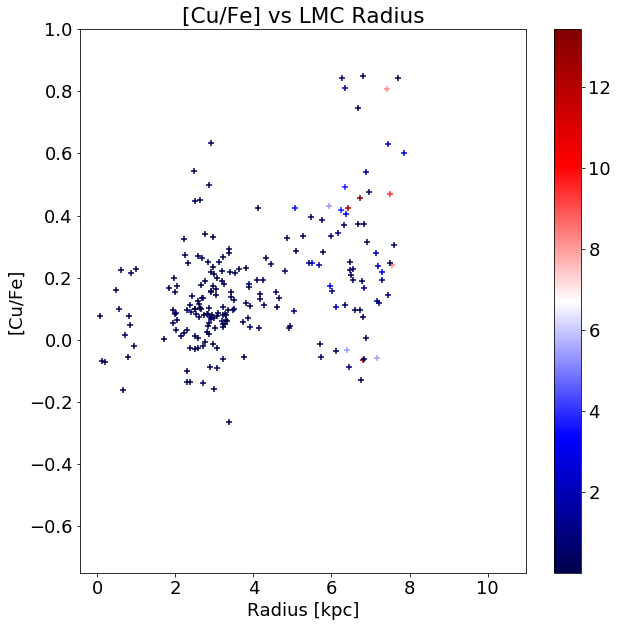

In [141]:
############################
### Abundance and Radius ###
############################

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['C_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-1,0.2)
plt.colorbar()
plt.title(r'[C/Fe] vs LMC Radius')
plt.savefig('parsec_rad_c.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['N_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.5,1)
plt.colorbar()
plt.title(r'[N/Fe] vs LMC Radius')
plt.savefig('parsec_rad_n.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['O_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.25,0.375)
plt.colorbar()
plt.title(r'[O/Fe] vs LMC Radius')
plt.savefig('parsec_rad_o.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['NA_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-1,1)
plt.colorbar()
plt.title(r'[Na/Fe] vs LMC Radius')
plt.savefig('parsec_rad_na.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['MG_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.2,0.5)
plt.colorbar()
plt.title(r'[Mg/Fe] vs LMC Radius')
plt.savefig('parsec_rad_mg.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['AL_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-1,0.125)
plt.colorbar()
plt.title(r'[Al/Fe] vs LMC Radius')
plt.savefig('parsec_rad_al.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['SI_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.25,0.25)
plt.colorbar()
plt.title(r'[Si/Fe] vs LMC Radius]')
plt.savefig('parsec_rad_si.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['K_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.5,1)
plt.colorbar()
plt.title(r'[K/Fe] vs LMC Radius')
plt.savefig('parsec_rad_k.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['CA_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.375,0.375)
plt.colorbar()
plt.title(r'[Ca/Fe] vs LMC Radius')
plt.savefig('parsec_rad_ca.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['CR_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-1,0.75)
plt.colorbar()
plt.title(r'[Cr/Fe] vs LMC Radius')
plt.savefig('parsec_rad_cr.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['MN_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.5,0.125)
plt.colorbar()
plt.title(r'[Mn/Fe] vs LMC Radius')
plt.savefig('parsec_rad_mn.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['CO_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-1,0.5)
plt.colorbar()
plt.title(r'[Co/Fe] vs LMC Radius')
plt.savefig('parsec_rad_co.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['NI_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.375,0.125)
plt.colorbar()
plt.title(r'[Ni/Fe] vs LMC Radius')
plt.savefig('parsec_rad_ni.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'][uage],dr16snr['CU_FE'][uage],marker='+',c=10**parage[cut][uage]/10**9,cmap='seismic')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'Radius [kpc]')
plt.ylim(-0.75,1)
plt.colorbar()
plt.title(r'[Cu/Fe] vs LMC Radius')
plt.savefig('parsec_rad_cu.pdf',bbox_inches='tight')
plt.show()

In [137]:
10**parage[cut]/10**9

array([ 4.43584207, 15.37502588, 16.76216367, ...,  1.6726903 ,
       26.01531829,  3.84736224])

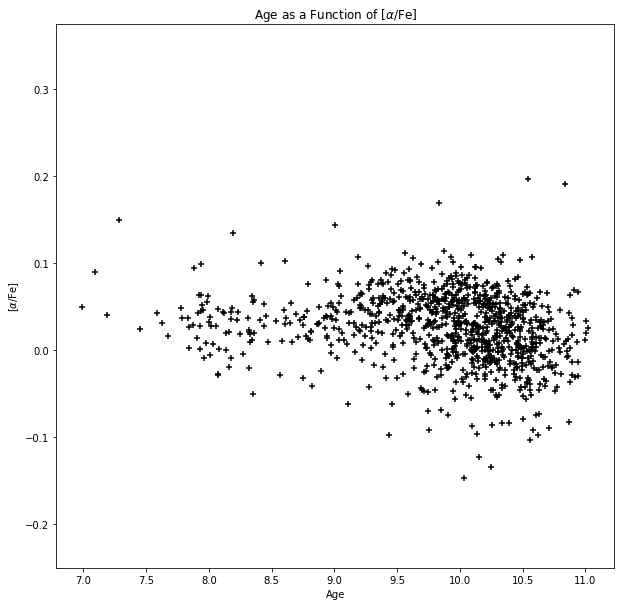

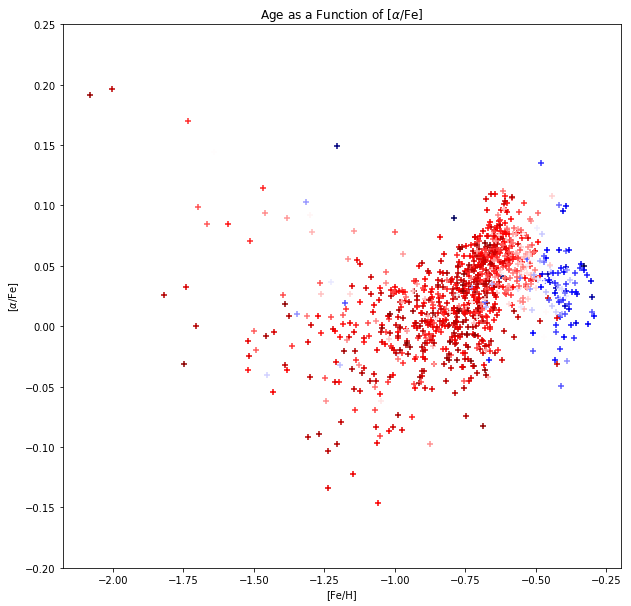

In [19]:
plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'],marker='+',c='k')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.375)
plt.title(r'Age as a Function of [$\alpha$/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'],marker='+',c=parage[young][cut],cmap='seismic')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'[Fe/H]')
plt.ylim(-0.2,0.25)
plt.title(r'Age as a Function of [$\alpha$/Fe]')
plt.savefig('parsec_alpha_fe.pdf',bbox_inches='tight')
plt.show()

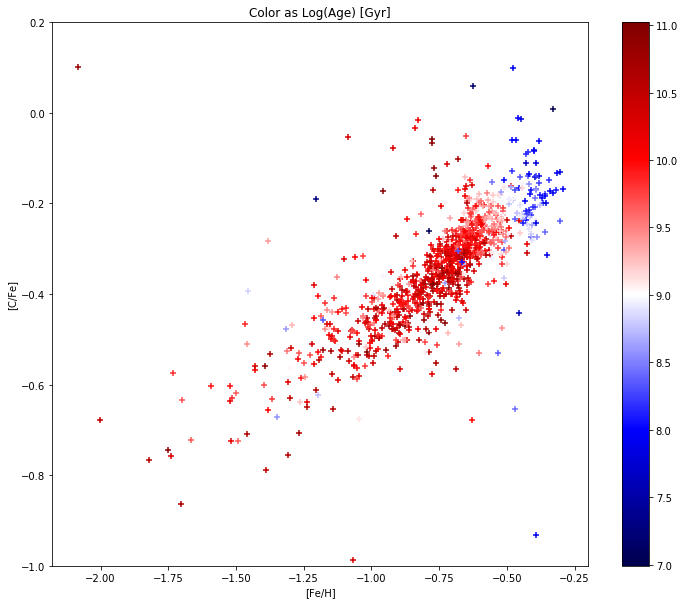

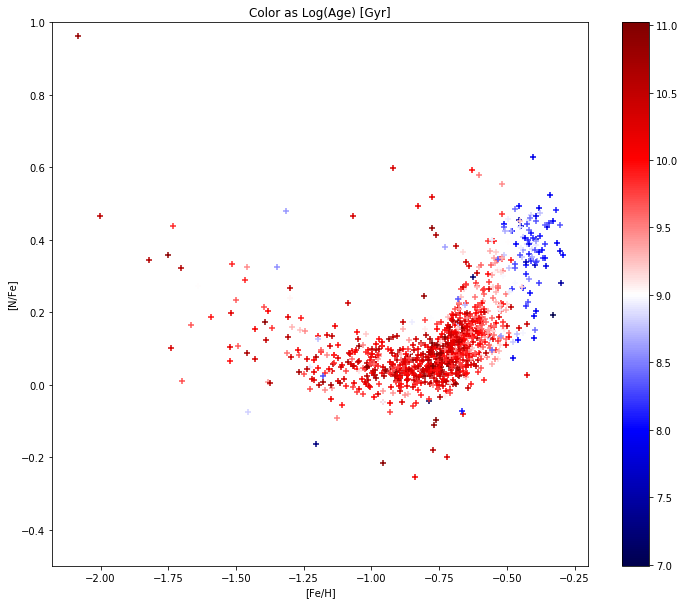

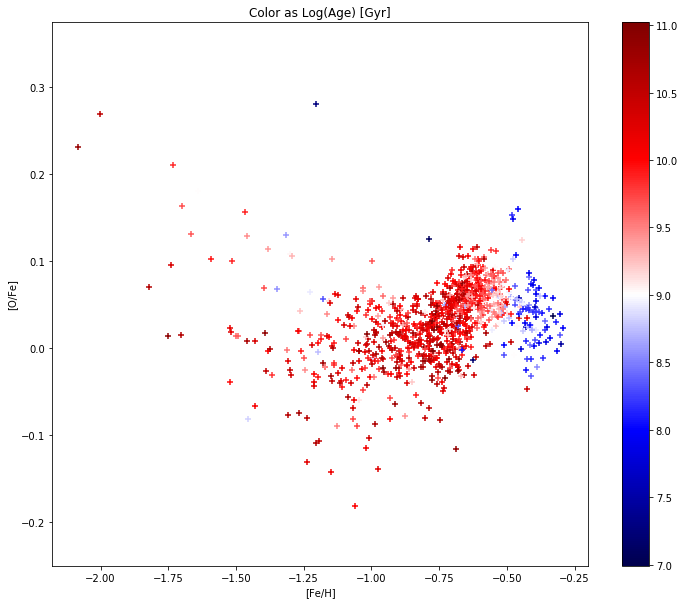

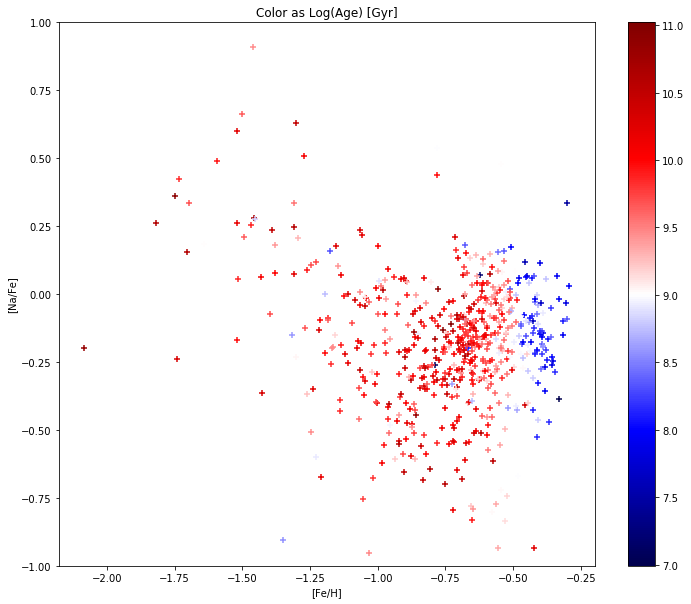

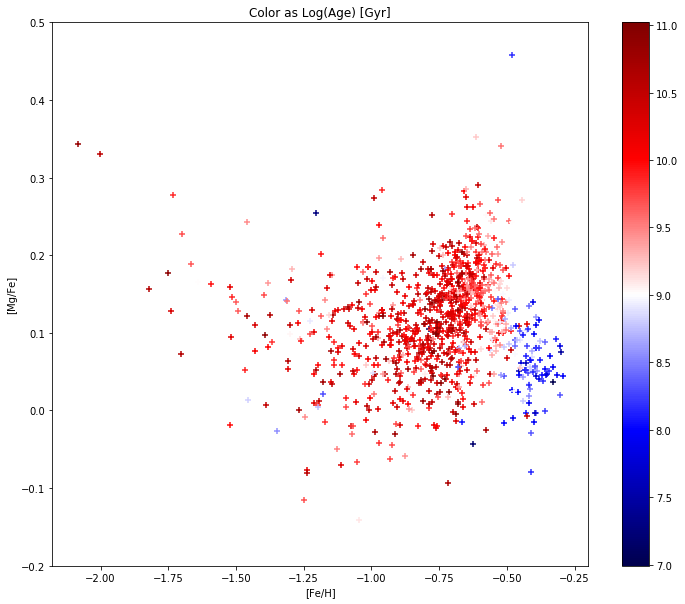

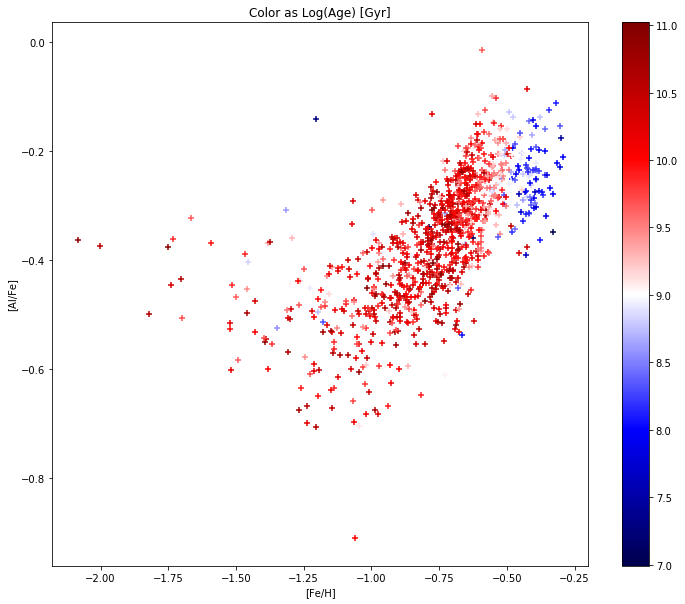

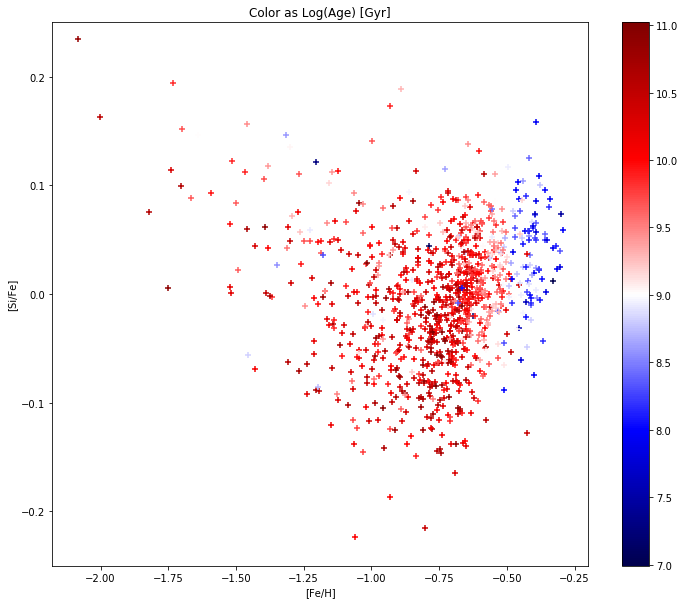

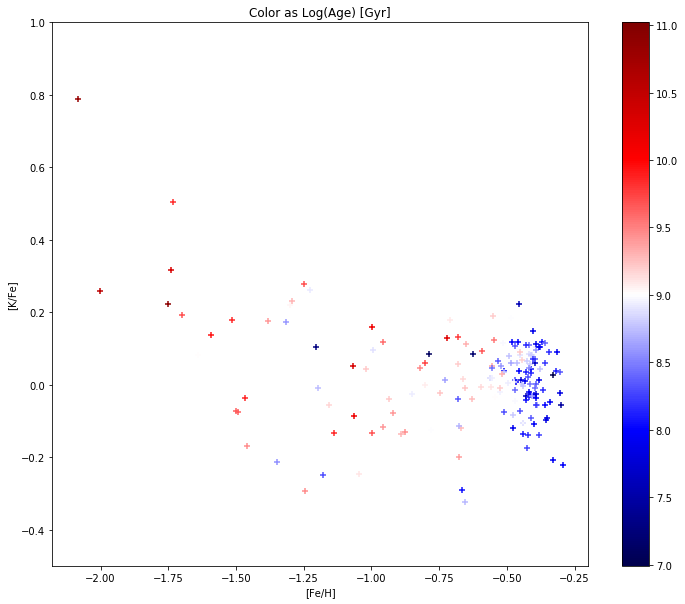

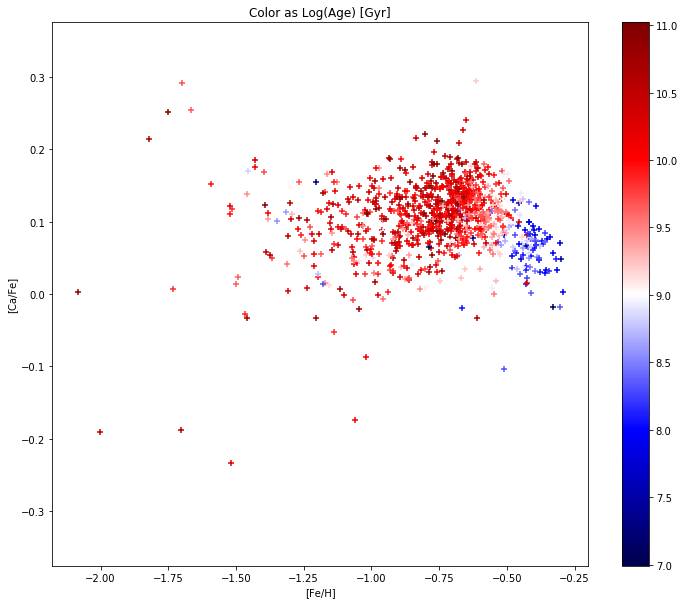

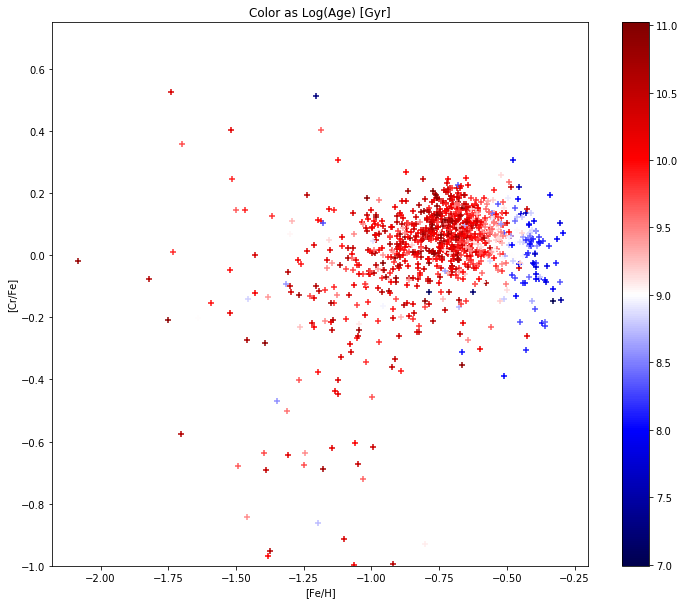

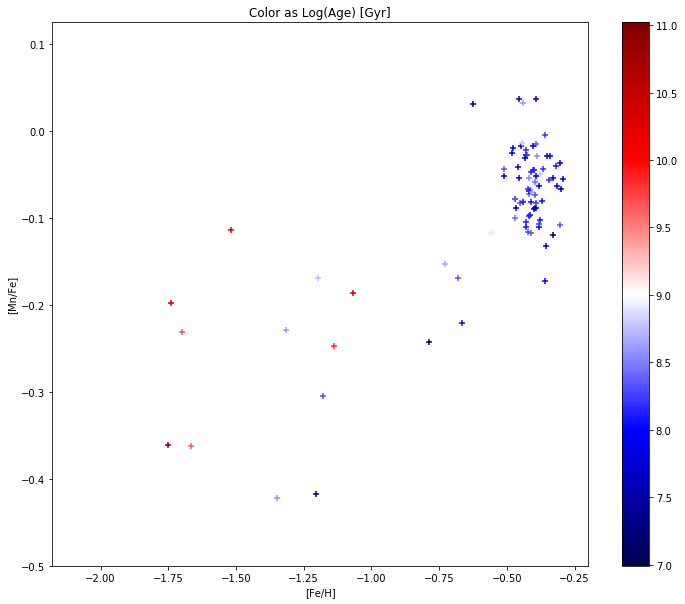

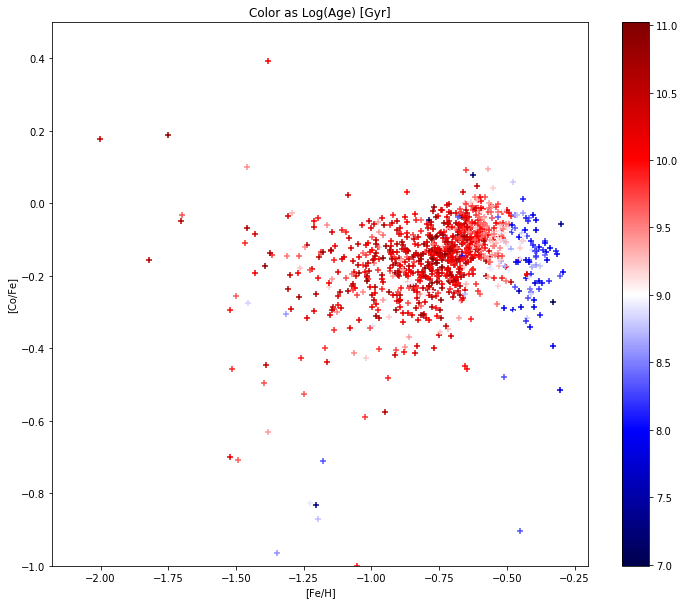

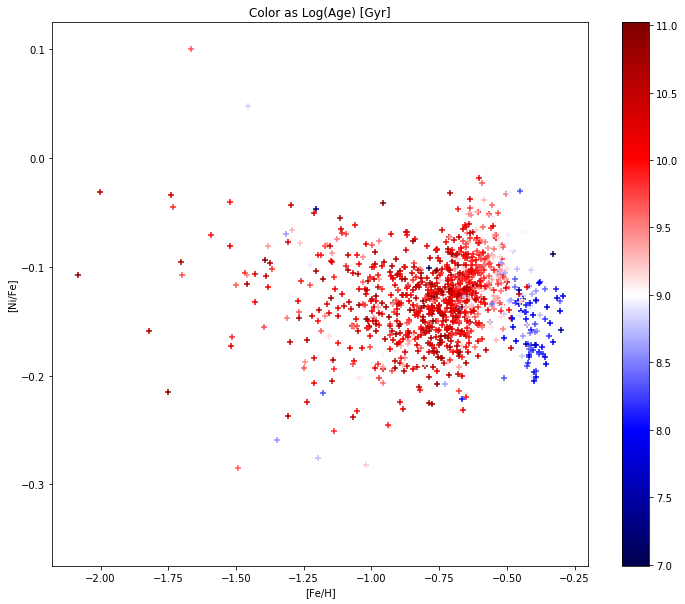

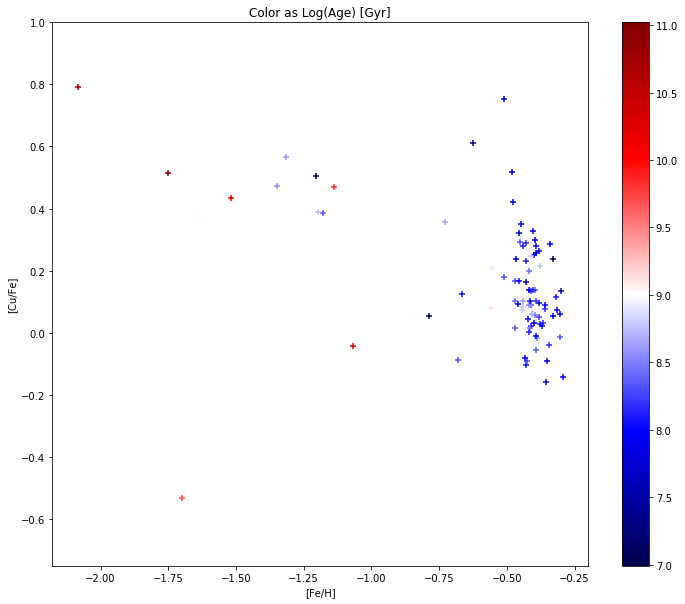

In [23]:
plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['C_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[C/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.ylim(-1,0.2)
plt.colorbar()
plt.savefig('parsec_c_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['N_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[N/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.5,1)
plt.savefig('parsec_n_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['O_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[O/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.25,0.375)
plt.savefig('parsec_o_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['Na_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Na/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-1,1)
plt.savefig('parsec_na_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['MG_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Mg/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.2,0.5)
plt.savefig('parsec_mg_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['AL_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Al/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
#plt.ylim(1,0.125)
plt.savefig('parsec_al_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['SI_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Si/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.25,0.25)
plt.savefig('parsec_si_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['K_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[K/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.5,1.0)
plt.savefig('parsec_k_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CA_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Ca/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.375,0.375)
plt.savefig('parsec_ca_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CR_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Cr/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-1,0.75)
plt.savefig('parsec_cr_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['MN_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Mn/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.5,0.125)
plt.savefig('parsec_mn_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CO_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Co/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-1,0.5)
plt.savefig('parsec_co_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['NI_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Ni/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.375,0.125)
plt.savefig('parsec_ni_fe.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CU_FE'],c=parage[young][cut],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[Cu/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.ylim(-0.75,1)
plt.savefig('parsec_cu_fe.pdf',bbox_inches='tight')
plt.show()

In [21]:
print(dr16snr['AL_FE'])

[-0.6370045  -0.49599457 -0.4479645  -0.52380455 -0.3374245  -0.29902452
 -0.2241945  -0.5129445  -0.5310044  -0.43720448 -0.35068452 -0.28055447
 -0.2892245  -0.38577455 -0.2725945  -0.35937446 -0.2957945  -0.15837452
 -0.35762453 -0.19563451 -0.4100145  -0.33333445 -0.29662448 -0.38588452
 -0.32877457 -0.2122345  -0.39310443 -0.2588445  -0.22679448 -0.23929447
 -0.5788045  -0.25233454 -0.23307446 -0.4840045  -0.24422449 -0.18072444
 -0.1930545  -0.24384448 -0.38964447 -0.3439945  -0.43297446 -0.2786645
 -0.1856445  -0.29106444 -0.4111945  -0.23836446 -0.4208145  -0.2512145
 -0.32485455 -0.2259345  -0.23489451 -0.2720945  -0.41249454 -0.5962044
 -0.3169645  -0.36929446 -0.25106454 -0.37508458 -0.12846449 -0.3744545
 -0.2969545  -0.24030447 -0.29750454 -0.23674446 -0.43981457 -0.42113447
 -0.3195145  -0.16407448 -0.3073045  -0.38530445 -0.29802448 -0.2951845
 -0.3064745  -0.17942452 -0.27176446 -0.5126144  -0.63390446 -0.23506448
 -0.2885045  -0.40932453 -0.3752145  -0.4277845  -0.3418

In [37]:
Chrismod.columns

<TableColumns names=('Time','SFR','Survivors','FeH','CFe','NFe','OFe','NaFe','MgFe','AlFe','SiFe','SFe','KFe','CaFe','TiFe','VFe','CrFe','MnFe','CoFe','NiFe')>

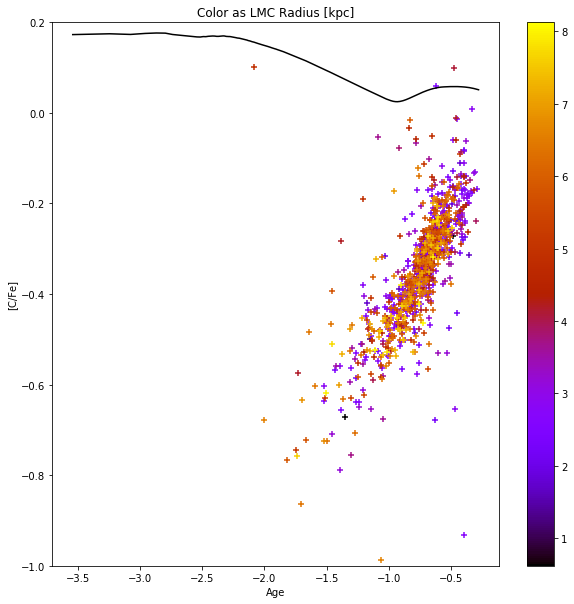

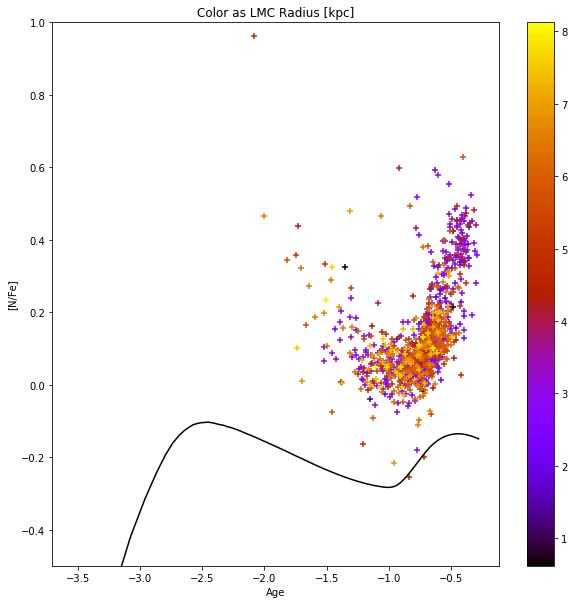

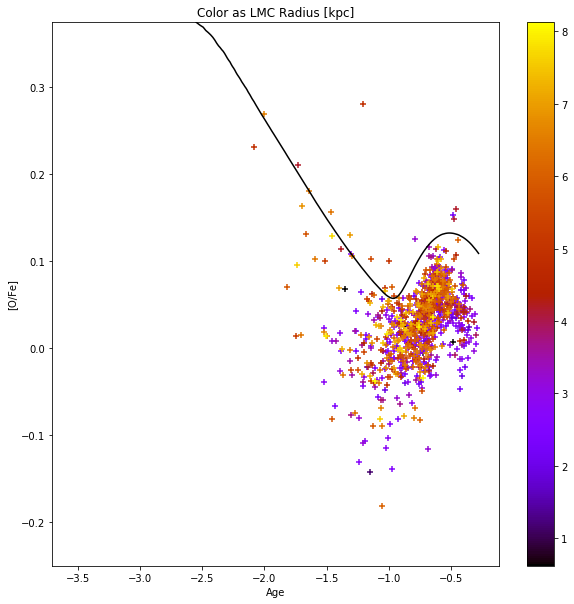

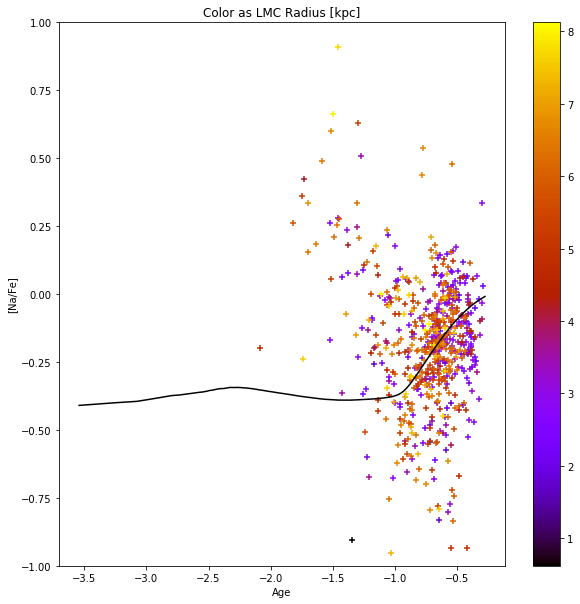

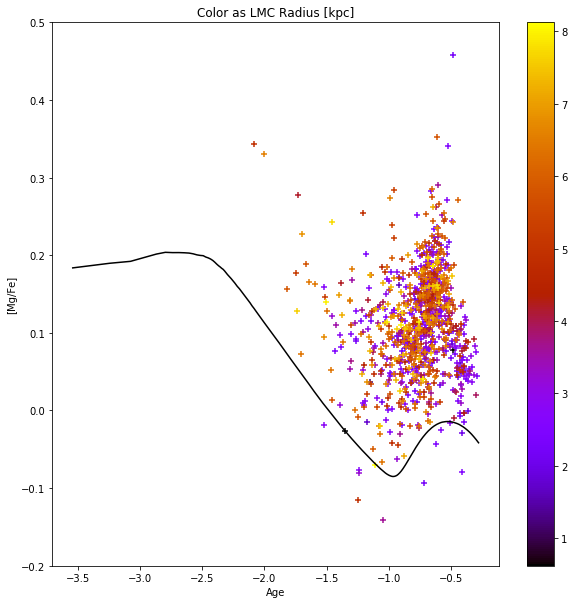

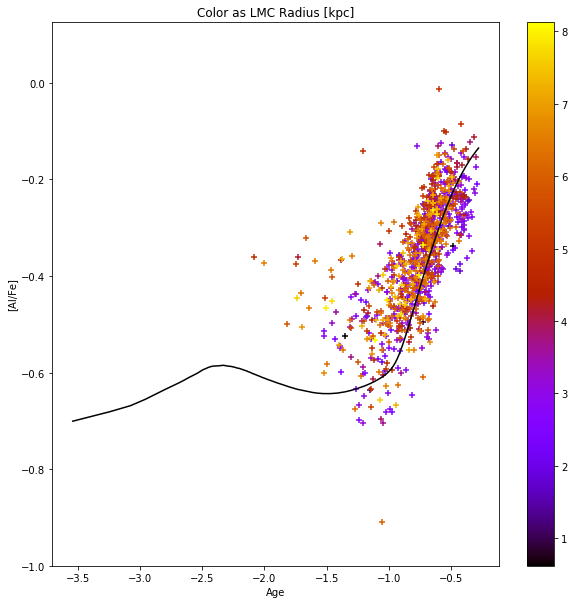

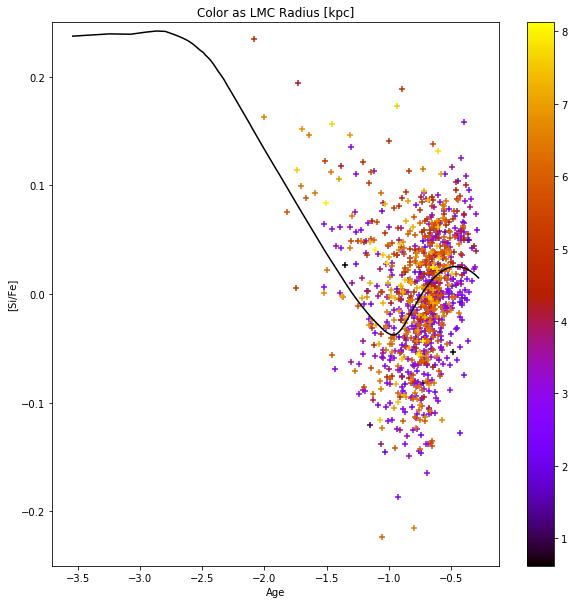

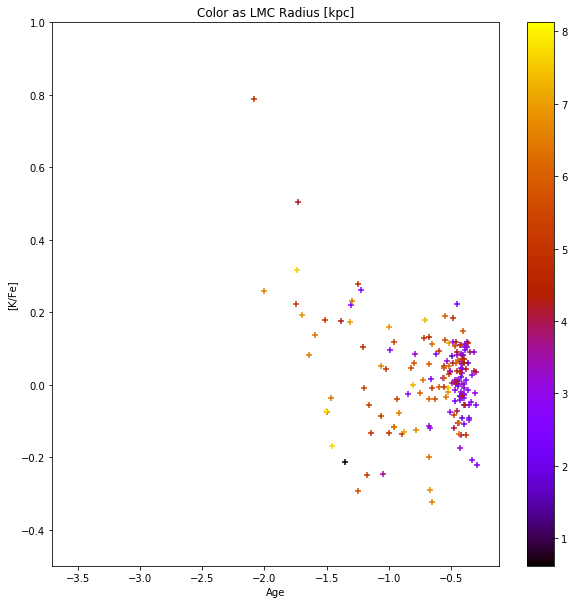

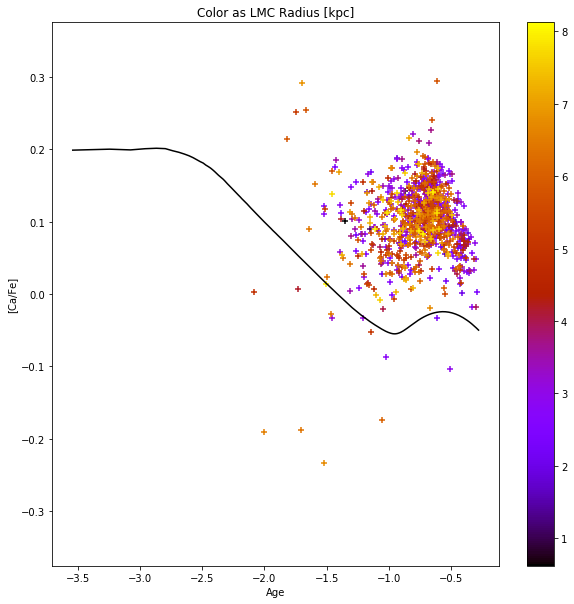

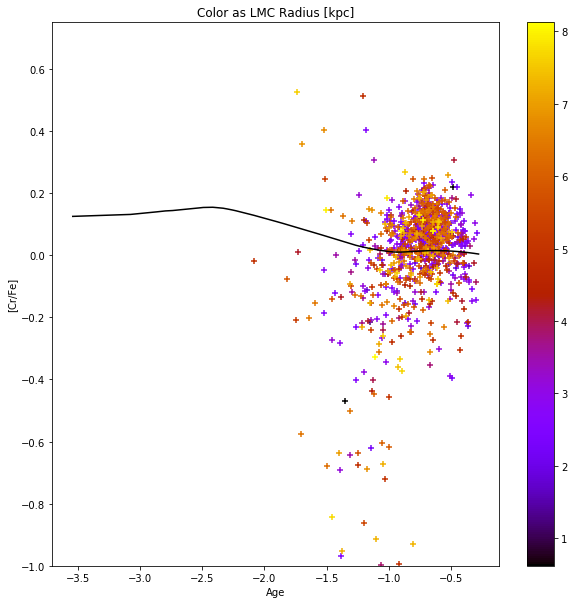

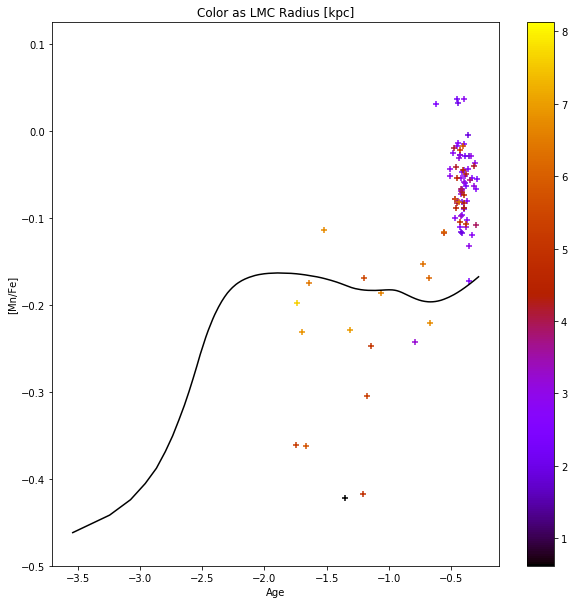

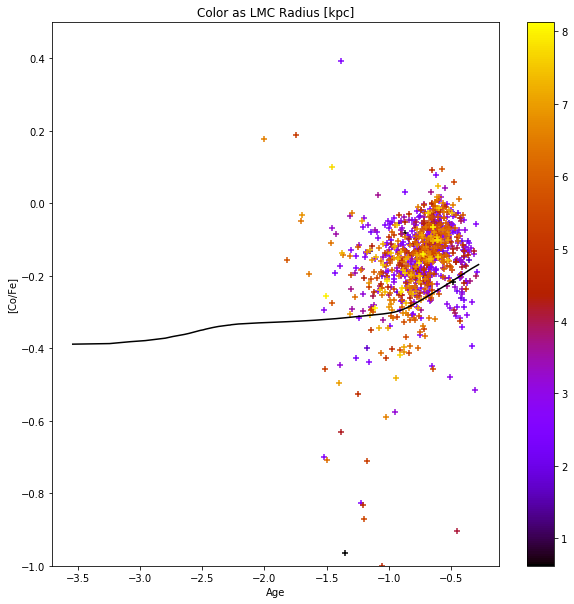

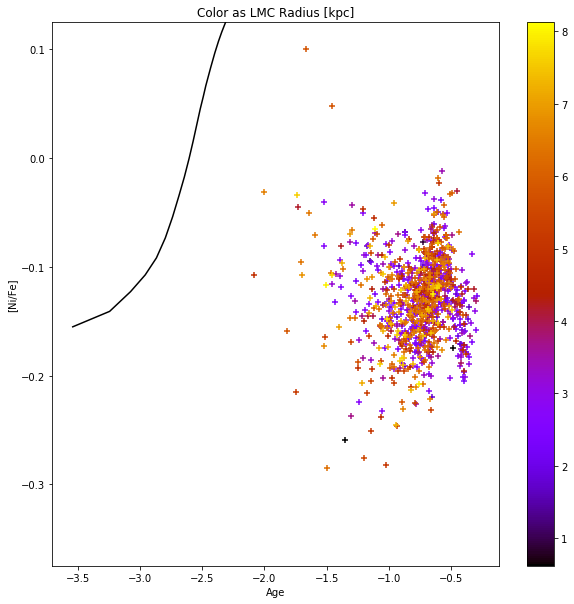

In [46]:
#########################
### Age and Abundance ###
#########################

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['C_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'][::-1],Chrismod['CFe'][::-1],c='k')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.2)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_c.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['N_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['NFe'],c='k')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_n.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['O_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['OFe'],c='k')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_o.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['NA_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['NaFe'],c='k')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,1)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_na.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['MG_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['MgFe'],c='k')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.2,0.5)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_mg.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['AL_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['AlFe'],c='k')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_al.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['SI_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['SiFe'],c='k')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.25)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_si.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['K_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['KFe'],c='k')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_k.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CA_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['CaFe'],c='k')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_ca.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CR_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['CrFe'],c='k')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.75)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_cr.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['MN_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['MnFe'],c='k')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_mn.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['CO_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['CoFe'],c='k')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.5)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_co.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['FE_H'],dr16snr['NI_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
plt.colorbar()
plt.plot(Chrismod['FeH'],Chrismod['NiFe'],c='k')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.125)
plt.title(r'Color as LMC Radius [kpc]')
plt.savefig('parsec_ni.pdf',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(dr16snr['FE_H'],dr16snr['CU_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
# plt.plot(Chrismod['FeH'],Chrismod['CuFe'],c='k')
# plt.ylabel(r'[Cu/Fe]')
# plt.xlabel(r'Age')
# plt.ylim(-0.75,1)
# plt.title(r'Color as LMC Radius [kpc]')
# # plt.colorbar()
# plt.savefig('parsec_age_cu.pdf',bbox_inches='tight')
# plt.show()

In [48]:
Chrismod['KFe']

<Column name='KFe' dtype='float64' length=433>
-1.13832
-1.13089
-1.12304
-1.11571
-1.10808
-1.10307
-1.09856
-1.09623
-1.09372
 -1.0914
-1.08968
-1.08843
     ...
 -1.0891
-1.08236
 -1.0756
-1.06888
-1.06212
-1.05553
  -1.049
-1.04256
-1.03617
-1.03002
-1.02391
-1.01796

In [156]:
import itertools as it

y1 = parsec['logTe']
y2 = parsec['Ksmag']
y3 = np.log10(parsec['Zini']/0.02)
y4  = parsec['logg']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

testmodels = []
testmodels_str = []
testall_var_str = ['y1','y2','y3','y12','y13','y23','y1sq','y2sq','y3sq']
testall_var = [y1,y2,y3,y12,y13,y23,y1sq,y2sq,y3sq]
for i in range(3, len(testall_var)+1):
    for testsubset in it.combinations(testall_var,i):
        testmodels.append(testsubset)
    for testsubset_str in it.combinations(testall_var_str,i):
        testmodels_str.append(np.array(testsubset_str))
    
testidx = []
for j in range(len(testmodels_str)):
    if testmodels_str[j][0]=='y1' and testmodels_str[j][1]=='y2' and testmodels_str[j][2]=='y3':
        testidx.append(j)
        
testmodels = np.array(testmodels)[testidx]
testmodels_str_good = np.array(testmodels_str)[testidx]

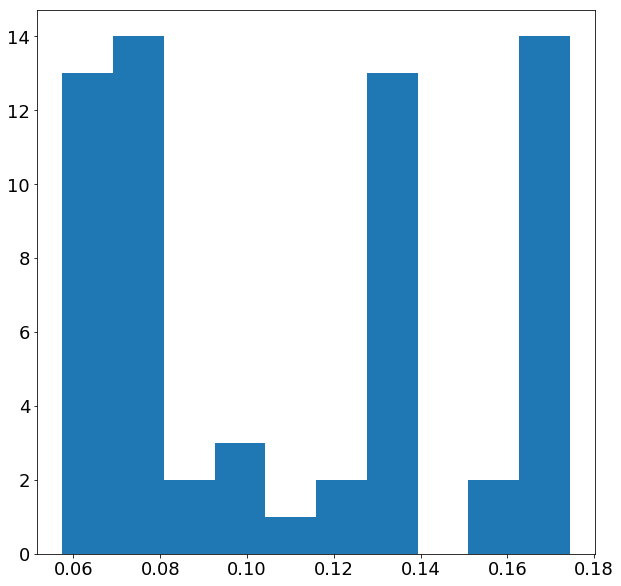

0.05746628233324458
[array(['y1', 'y2', 'y3', 'y12', 'y13', 'y23', 'y1sq', 'y2sq', 'y3sq'],
      dtype='<U4')]
[array([ 1.05592462e+03, -5.37776305e+02,  1.36790634e+01, -2.95641452e+01,
       -3.57645238e+00,  7.54638396e+00, -9.45698641e-02,  6.88765399e+01,
        6.06345313e-03, -3.04370753e-01])]


In [157]:
import statsmodels.api as sm 

testmodel_mads = []
testmodel_params = []
testmodel_res = []
for i in range(len(testmodels)):
    testpmodl = np.array(testmodels[i]).T
    testpmodl = sm.add_constant(testpmodl)
    testmodel = sm.OLS(parsec['logAge'],testpmodl).fit()
    testpredictions = testmodel.predict(testpmodl)
    testresidual = testpredictions - parsec['logAge']
    testmodel_res.append(max(np.absolute(testresidual)))
    testmodel_mads.append(mad(testresidual))
    testmodel_params.append(np.asarray(testmodel.params))
    
plt.figure(figsize=[10,10])
plt.hist(testmodel_mads)
plt.show()
    
best = np.where(testmodel_mads == min(testmodel_mads))
print(min(testmodel_mads))
print(testmodels_str_good[best])
print(np.asarray(testmodel_params)[best])

In [4]:
def testparfit(x1,x2,x3):
    p = [ 1.05592462e+03, -5.37776305e+02,  1.36790634e+01, -2.95641452e+01,\
       -3.57645238e+00,  7.54638396e+00, -9.45698641e-02,  6.88765399e+01,\
        6.06345313e-03, -3.04370753e-01]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)\
+p[6]*np.multiply(x2,x3)+p[7]*x1**2+p[8]*x2**2+p[9]*x3**2

In [193]:
dr16snr = clndr16


In [8]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

In [5]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscor = np.log10(0.638*(np.asarray(factsCN)+0.362))

uncteff = []
for i in range(len(clndr16)):
    uncteff.append(clndr16['FPARAM'][i][0])

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
testparage = testparfit(np.log10(uncteff),corabsK,sal(clndr16['M_H'],metscor))

In [6]:
###
### Old File New Model
###

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clnrolddr16)):
    x_C.append(sol_xm[0]*10**(clnrolddr16['C_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_N.append(sol_xm[1]*10**(clnrolddr16['N_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_O.append(sol_xm[2]*10**(clnrolddr16['O_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clnrolddr16['Mg_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clnrolddr16['Ca_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_S.append(sol_xm[5]*10**(clnrolddr16['S_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clnrolddr16['SI_FE']+clnrolddr16['FE_H']-clnrolddr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clnrolddr16['FE_H']-clnrolddr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
for j in range(len(clnrolddr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscorrold = np.log10(0.638*(np.asarray(factsCN)+0.362))

uncteff = []
for i in range(len(clnrolddr16)):
    uncteff.append(clnrolddr16['FPARAM'][i][0])

stardistold = dist2LMCtest(clnrolddr16['RA'],clnrolddr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsKold = absmag(clnrolddr16['K'],stardistold,False)-clnrolddr16['AK_TARG']
testparageold = testparfit(np.log10(uncteff),corabsKold,clnrolddr16['M_H']+metscorrold)

In [7]:
def newnoisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    #lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    #lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew

In [263]:
devs = []

for i in range(len(clnrolddr16)):
    lgT = np.log10(clnrolddr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clnrolddr16['TEFF_ERR'][i])/np.log10(clnrolddr16['TEFF'][i]))
    ks = corabsKold[i]
    ksERR = clnrolddr16['K_ERR'][i]
    mh = clnrolddr16['M_H'][i]
    mhERR = clnrolddr16['M_H_ERR'][i]
#     am = clndr16['ALPHA_M'][i]
#     amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clnrolddr16['C_FE'][i]
    cfeERR = clnrolddr16['C_FE_ERR'][i]
    nfe = clnrolddr16['N_FE'][i]
    nfeERR = clnrolddr16['N_FE_ERR'][i]
    feh = clnrolddr16['FE_H'][i]
    fehERR = clnrolddr16['FE_H_ERR'][i]
    lgg = clnrolddr16['LOGG'][i]
    lggERR = clnrolddr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac = newnoisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR)
        ages.append(testparfit(nlgT,nks,sal(nmh,nfac)))
    
    devs.append(mad(ages))

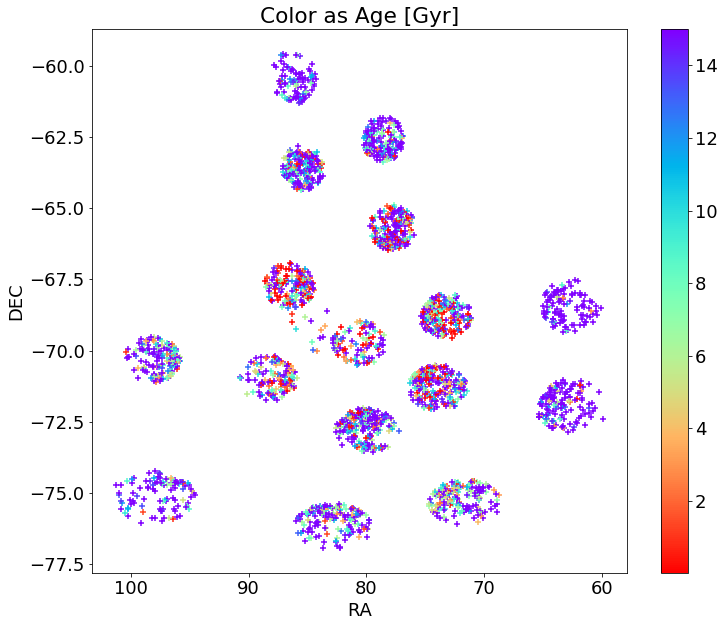

In [417]:
agecut = np.where(testparage<10.13)

plt.figure(figsize=[12,10])
#plt.scatter(clndr16['RA'][agecut],clndr16['DEC'][agecut],c=10**testparage[agecut]/10**9,marker='+',cmap='seismic')
plt.scatter(clndr16['RA'],clndr16['DEC'],c=10**testparage/10**9,marker='+',cmap='rainbow_r',vmax=15)

plt.colorbar()
plt.gca().invert_xaxis()
plt.title(r'Color as Age [Gyr]')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.savefig('parsec_pos_age.pdf',bbox_inches='tight')
plt.show()

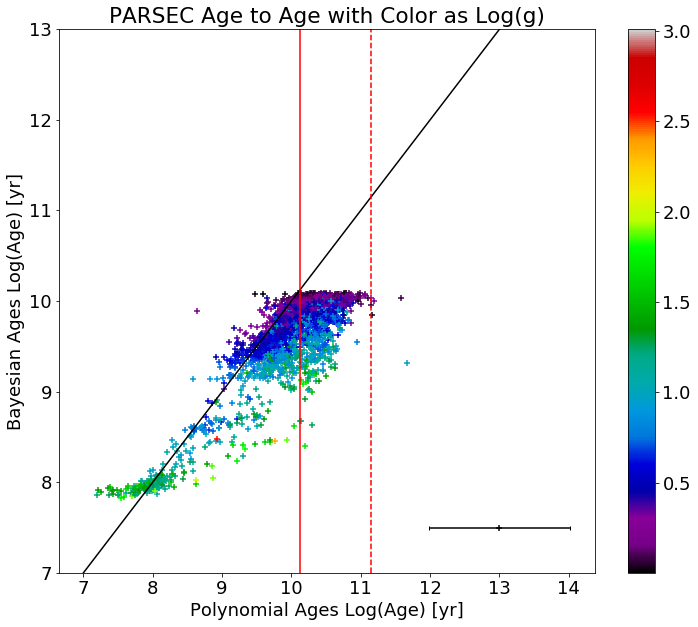

In [267]:
#lowgrav = np.where(clndr16['LOGG']<0.20)
plt.figure(figsize=[12,10])
plt.scatter(testparageold,clnpdfout['P_MEAN'],c=clnrolddr16['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='k')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+np.mean(devs),c='r',linestyle='--')
plt.xlabel(r'Polynomial Ages Log(Age) [yr]')
plt.ylabel(r'Bayesian Ages Log(Age) [yr]')
plt.title(r'PARSEC Age to Age with Color as Log(g)')
plt.savefig('parsec_age_age.pdf',bbox_inches='tight')
plt.show()

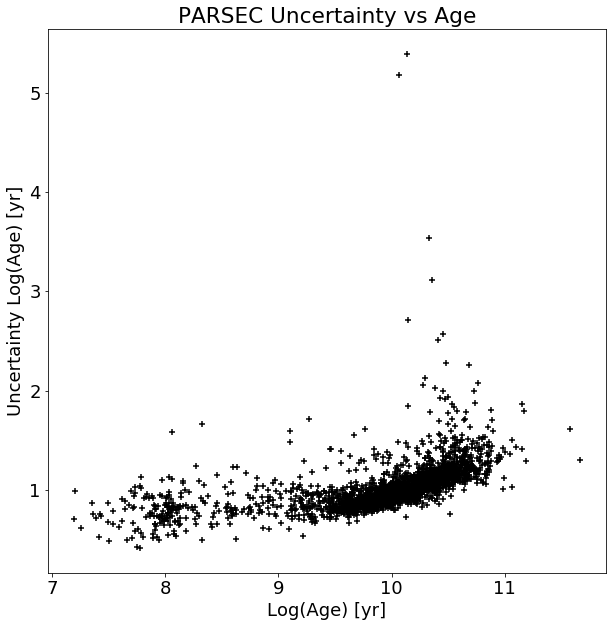

In [276]:
plt.figure(figsize=[10,10])
plt.scatter(10testparageold,devs,c='k',marker='+',label='Polynomial')
#plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Bayesian')
#plt.xlim(7,13)
#plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
#plt.ylim(0.1,0.5)
plt.title(r'PARSEC Uncertainty vs Age')
#plt.legend()
plt.savefig('parsec_uncert_age.pdf',bbox_inches='tight')
plt.show()

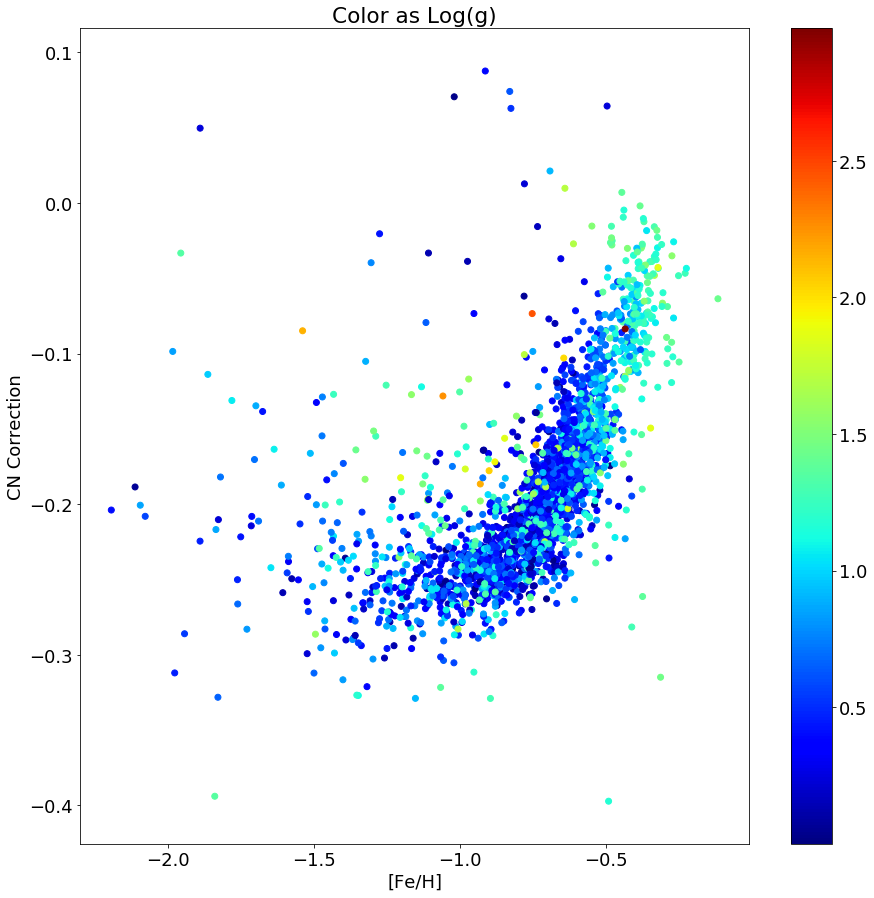

In [285]:
plt.figure(figsize=[15,15])
plt.scatter(dr16snr['FE_H'],metscorr,c=dr16snr['LOGG'],cmap='jet')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'CN Correction')
plt.title(r'Color as Log(g)')
plt.colorbar()
plt.savefig('parsec_CN.pdf',bbox_inches='tight')
plt.show()

In [377]:
xy, x_ind, y_ind = np.intersect1d(clnrolddr16['APOGEE_ID'], dr16snr['APOGEE_ID'],\
                                  return_indices=True)

dr16snr[x_ind]
#clnpdfout[y_ind]

len(clnpdfout[x_ind])
len(dr16snr[y_ind])

2267

In [332]:
len(np.where(np.in1d(clnrolddr16['APOGEE_ID'], dr16snr['APOGEE_ID'])==True)[0])

2267

In [344]:
# idx = []

# for i in clnrolddr16['APOGEE_ID']:
#     idx.append(np.squeeze(np.where(dr16snr['APOGEE_ID']==i)))
    
# indices = idx

In [338]:
len(idx)

2307

In [329]:
np.where((clnrolddr16['APOGEE_ID'][indices]==dr16snr['APOGEE_ID'][indices])==True)

(array([0, 1, 2, 3, 4]),)

In [323]:
len(np.where(np.in1d(dr16snr['APOGEE_ID'], clnrolddr16['APOGEE_ID']))[0])

2267

TypeError: You must first set_array for mappable

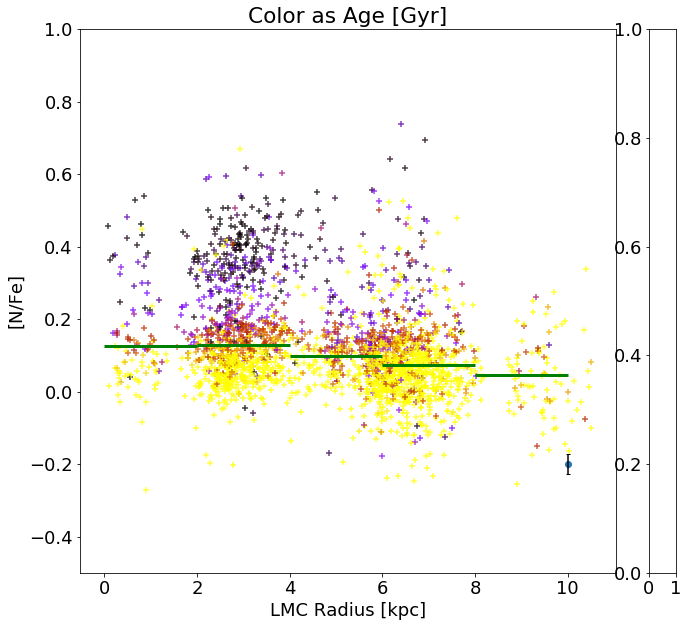

In [418]:
# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['C_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['C_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['CFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[C/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_c.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[12,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['N_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['N_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['NFe'],c='k',label='Evolution Model')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.2)
plt.errorbar(10,-0.2,yerr=np.mean(dr16snr['N_FE_ERR']),c='k',capsize=2)
plt.ylim(-0.5,1.0)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('parsec_age_n.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['O_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['O_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['OFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[O/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-0.25,0.375)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_o.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['NA_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['NA_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['NaFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Na/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1.0,1.0)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_na.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['MG_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['MG_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['MgFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Mg/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-0.2,0.5)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_mg.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['AL_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['AL_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['AlFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Al/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.125)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_al.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['SI_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['SI_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['SiFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Si/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-0.25,0.25)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_si.jpg',bbox_inches='tight')
# plt.show()

# # plt.figure(figsize=[10,10])
# # plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# # bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# # plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# # plt.plot(chrisage/10**9,Chrismod['KFe'],c='k',label='Evolution Model')
# # plt.ylabel(r'[K/Fe]')
# # plt.xlabel(r'Age [Gyr]')
# # plt.ylim(-0.5,1.0)
# # #plt.xscale('log')
# # plt.title(r'Color as LMC Radius [kpc]')
# # plt.colorbar()
# # plt.legend()
# # plt.savefig('parsec_age_k.jpg',bbox_inches='tight')
# # plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['CA_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['CA_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['CaFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Ca/Fe]')
# plt.title(r'Color as Age [Gyr]')
# plt.ylim(-0.375,0.375)
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_ca.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['CR_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['CR_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['CrFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Cr/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.75)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_cr.jpg',bbox_inches='tight')
# plt.show()

# # plt.figure(figsize=[10,10])
# # plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# # bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# # plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# # plt.plot(chrisage/10**9,Chrismod['MnFe'],c='k',label='Evolution Model')
# # plt.ylabel(r'[Mn/Fe]')
# # plt.xlabel(r'Age [Gyr]')
# # plt.ylim(-0.5,0.125)
# # plt.title(r'Color as LMC Radius [kpc]')
# # plt.colorbar()
# # plt.legend()
# # plt.savefig('parsec_age_mn.jpg',bbox_inches='tight')
# # plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['CO_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['CO_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Co/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.5)
# #plt.xscale('log')
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_co.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['NI_FE'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['NI_FE'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['NiFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Ni/Fe]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-0.375,0.125)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_ni.jpg',bbox_inches='tight')
# plt.show()

# plt.figure(figsize=[12,10])
# plt.scatter(dr16snr['LMCRAD'],dr16snr['FE_H'],marker='+',c=10**testparage/10**9,cmap='gnuplot',alpha=0.75,label='Data',vmax=14)
# bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['LMCRAD'],dr16snr['FE_H'],statistic='median', bins=[0,2,4,6,8,10])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
# #plt.plot(chrisage/10**9,Chrismod['FeH'],c='k',label='Evolution Model')
# plt.ylabel(r'[Fe/H]')
# plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-2.5,-0.25)
# plt.title(r'Color as Age [Gyr]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_fe.jpg',bbox_inches='tight')
# plt.show()

# # plt.figure(figsize=[10,10])
# # plt.scatter(10**parage[young][cut],dr16snr['CU_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
# # plt.plot(chrisage,Chrismod['CuFe'],c='k')
# # plt.ylabel(r'[Cu/Fe]')
# # plt.xlabel(r'Age')
# # plt.ylim(-0.75,1)
# # plt.xscale('log')
# # plt.title(r'Color as LMC Radius [kpc]')
# # plt.colorbar()
# # plt.savefig('parsec_age_cu.pdf',bbox_inches='tight')

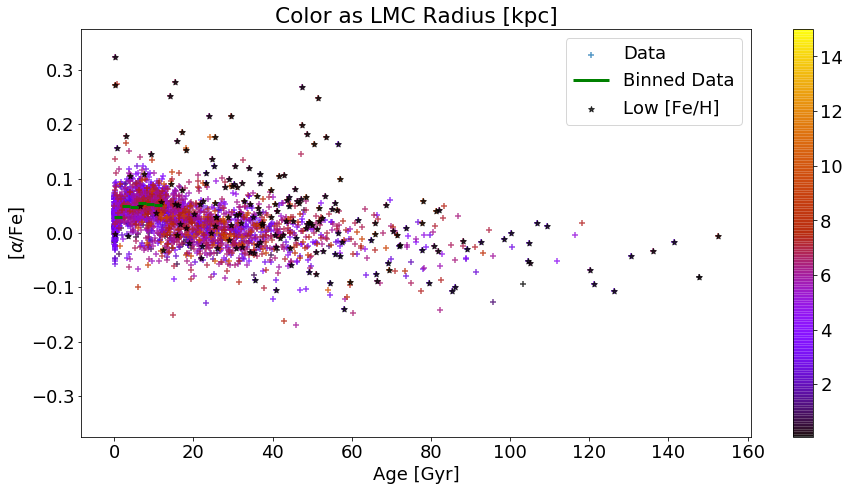

In [242]:
metpor = np.where(dr16snr['FE_H']<-1.2)

plt.figure(figsize=[15,7.5])
plt.scatter(10**testparage/10**9,(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H']),marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot',alpha=0.75,label='Data',vmax=15)
bin_means, bin_edges, binnumber = st.binned_statistic(10**testparage/10**9,(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H']), statistic='median', bins=[0,2,4,6,8,10,12])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CaFe'],c='k',label='Evolution Model')
plt.colorbar()
plt.scatter(10**testparage[metpor]/10**9,(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'])[metpor],marker='*',c='k',cmap='gnuplot',alpha=0.75,label='Low [Fe/H]',vmax=15)
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'Age [Gyr]')
plt.ylim(-0.375,0.375)
# plt.xlim(0,15.0)
plt.title(r'Color as LMC Radius [kpc]')
plt.legend()
plt.savefig('parsec_age_alpha.jpg',bbox_inches='tight')
plt.show()

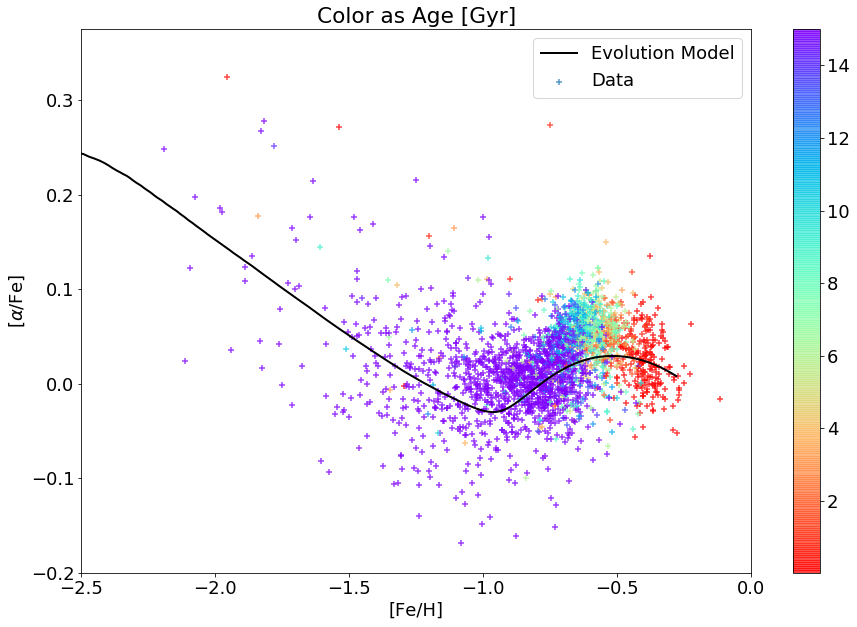

In [469]:
alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)
plt.figure(figsize=[15,10])
plt.scatter(dr16snr['FE_H'],(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H']),marker='+',c=10**testparage/10**9,cmap='rainbow_r',alpha=0.75,label='Data',vmax=15.0)
#bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr['FE_H'][agecut],(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'])[agecut], statistic='median', bins=[0,2,4,6,8,10,12])
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
plt.plot(Chrismod['FeH'],alphachris,c='k',label='Evolution Model',lw=2)

plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'[Fe/H]')
plt.ylim(-0.375,0.375)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.xlim(-2.5,0.0)
plt.legend()
plt.ylim(-0.2,0.375)
plt.savefig('parsec_alpha_fe.jpg',bbox_inches='tight')
plt.show()

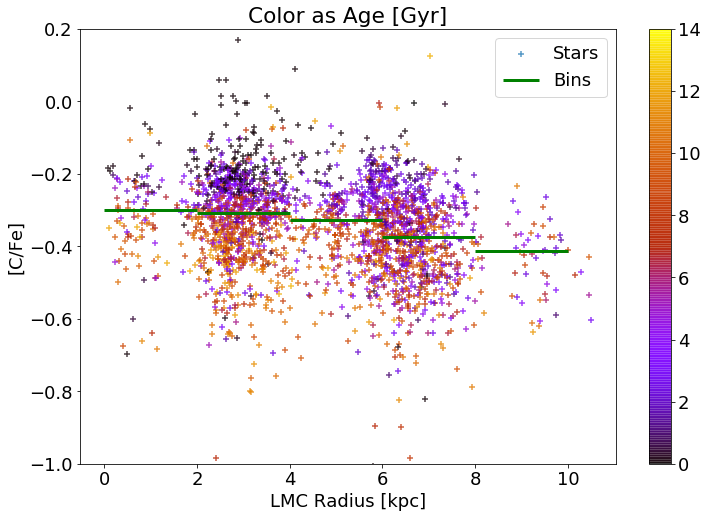

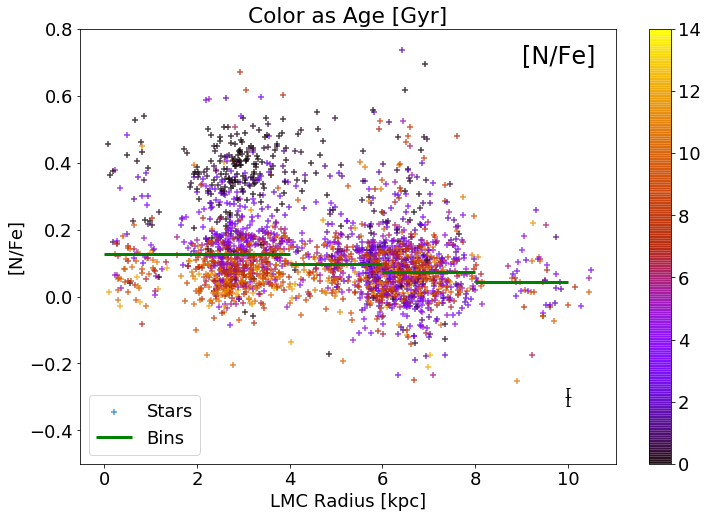

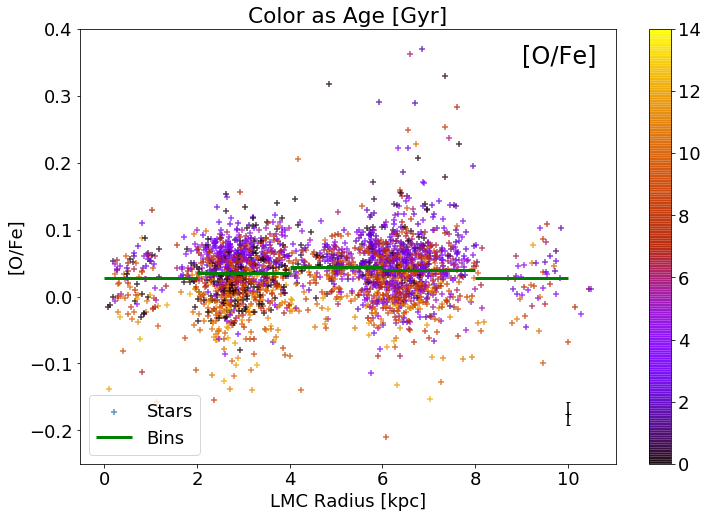

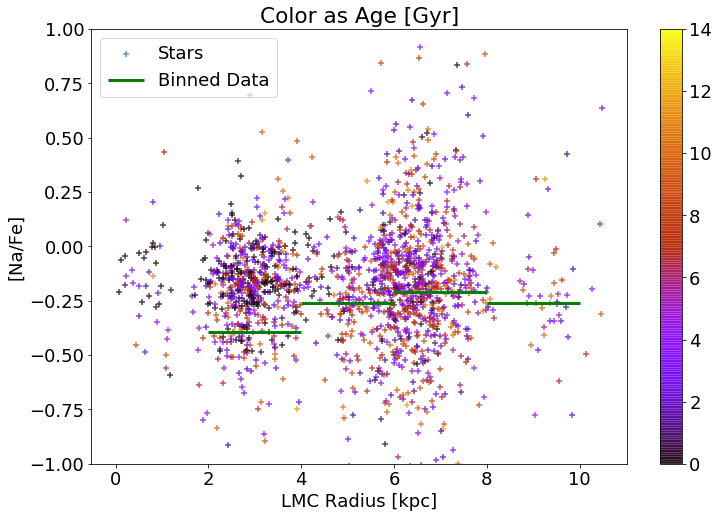

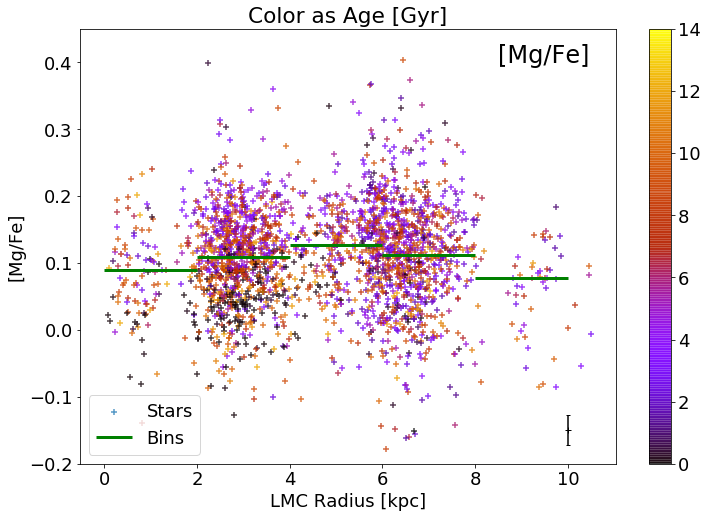

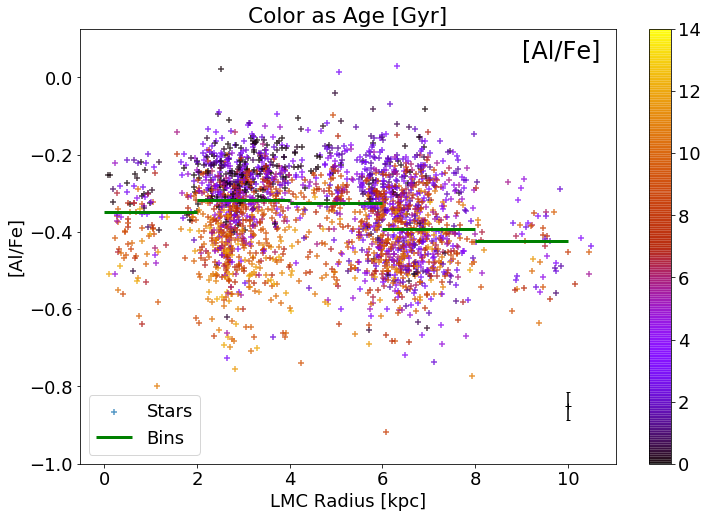

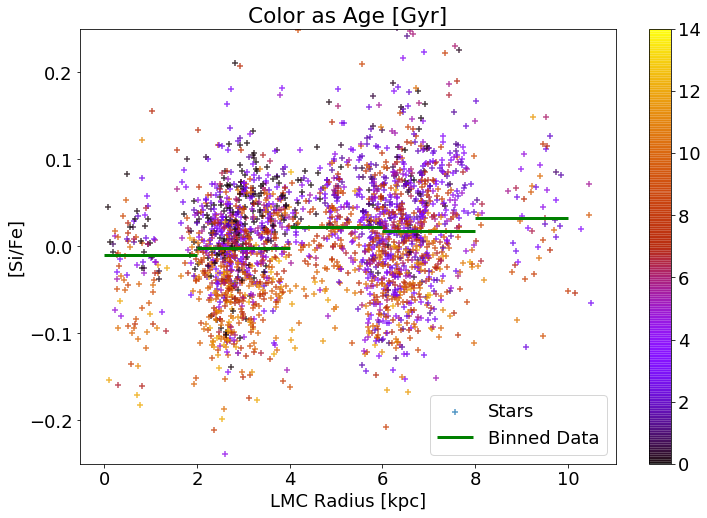

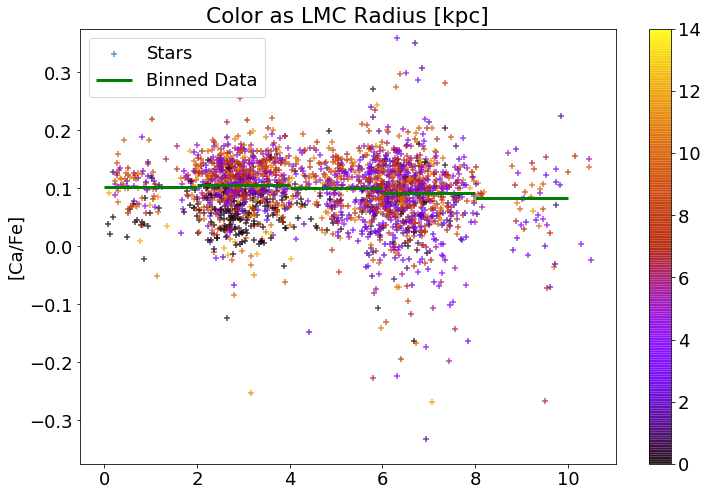

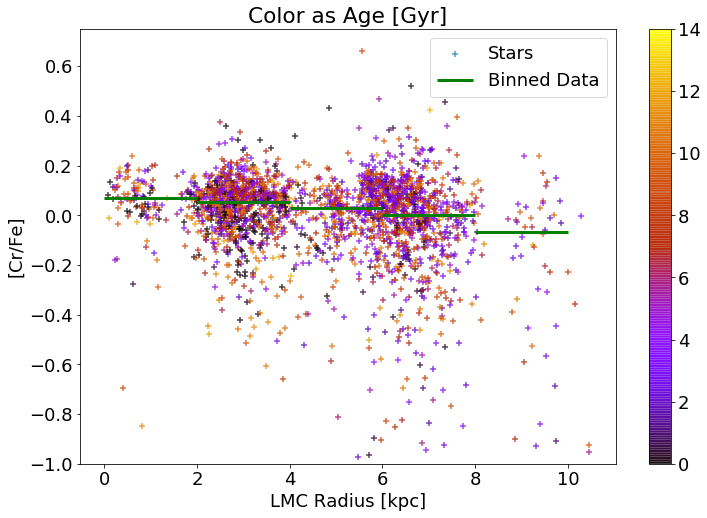

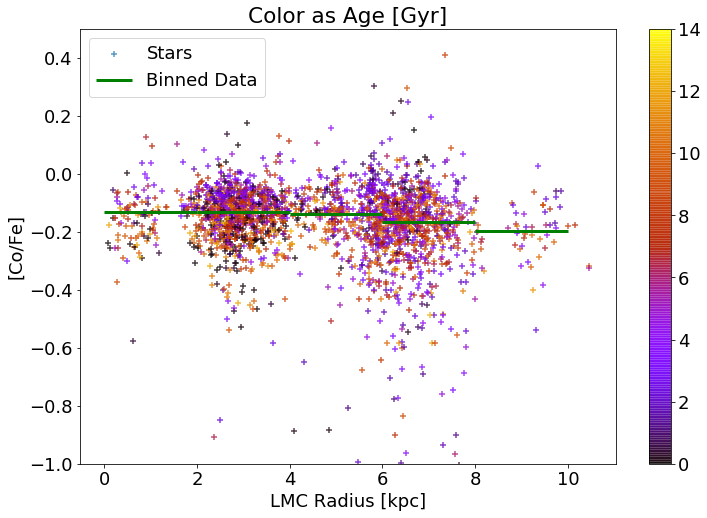

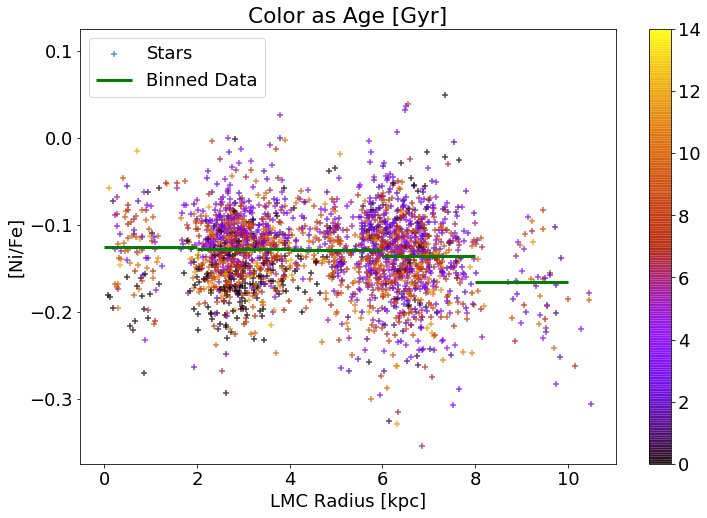

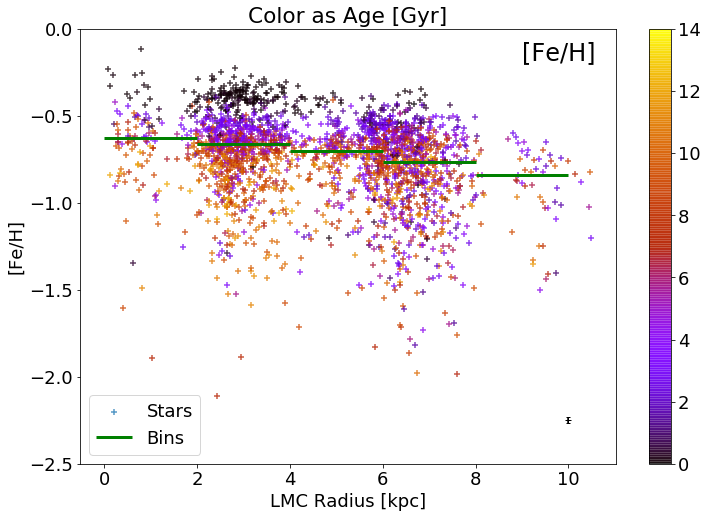

In [477]:
###
### Diane's Ages
###

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['C_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['C_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['CFe'],c='k',label='Evolution Model')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.2)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_c.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['N_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['N_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['NFe'],c='k',label='Evolution Model')
plt.colorbar()
plt.xlabel(r'LMC Radius [kpc]')
plt.ylabel(r'[N/Fe]')
plt.ylim(-0.5,0.8)
plt.title(r'Color as Age [Gyr]')
plt.errorbar(10,-0.3,marker='+',yerr=np.mean(dr16snr['N_FE_ERR']),c='k',capsize=2)
plt.text(9, 0.7, r'[N/Fe]', fontsize=24)
plt.legend(loc='lower left')
plt.savefig('dparsec_age_n.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['O_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['O_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['OFe'],c='k',label='Evolution Model')
plt.colorbar()
plt.xlabel(r'LMC Radius [kpc]')
plt.ylabel(r'[O/Fe]')
plt.ylim(-0.25,0.4)
plt.title(r'Color as Age [Gyr]')
plt.errorbar(10,-0.175,marker='+',yerr=np.mean(dr16snr['O_FE_ERR']),c='k',capsize=2)
plt.text(9, 0.35, r'[O/Fe]', fontsize=24)
plt.legend(loc='lower left')
plt.savefig('dparsec_age_o.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['NA_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['NA_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['NaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1.0,1.0)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_na.jpg',bbox_inches='tight')
plt.show()

mgerr = np.where(dr16snr['MG_FE_ERR']>-100)

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['MG_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['MG_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['MgFe'],c='k',label='Evolution Model')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylabel(r'[Mg/Fe]')
plt.ylim(-0.2,0.45)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.errorbar(10,-0.15,marker='+',yerr=np.mean(dr16snr['MG_FE_ERR'][mgerr]),c='k',capsize=2)
plt.text(8.5, 0.4, r'[Mg/Fe]', fontsize=24)
plt.legend(loc='lower left')
plt.savefig('dparsec_age_mg.jpg',bbox_inches='tight')
plt.show()

alerr = np.where(dr16snr['AL_FE_ERR']>-100)

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['AL_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['AL_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['AlFe'],c='k',label='Evolution Model')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylabel(r'[Al/Fe]')
plt.ylim(-1,0.125)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.errorbar(10,-0.85,marker='+',yerr=np.mean(dr16snr['AL_FE_ERR'][alerr]),c='k',capsize=2)
plt.text(9, 0.05, r'[Al/Fe]', fontsize=24)
plt.legend(loc='lower left')
plt.savefig('dparsec_age_al.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['SI_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['SI_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['SiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.25,0.25)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_si.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['K_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['KFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[K/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,1.0)
# #plt.xscale('log')
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_k.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['CA_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['CA_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CaFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ca/Fe]')
plt.title(r'Color as Age [Gyr]')
plt.ylim(-0.375,0.375)
plt.title(r'Color as LMC Radius [kpc]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_ca.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['CR_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['CR_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CrFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.75)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_cr.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage],marker='+',c=dr16snr['LMCRAD'][uage],cmap='gnuplot',alpha=0.75,label='Data')
# bin_means, bin_edges, binnumber = st.binned_statistic(10**parage[young][cut][uage]/10**9,dr16snr['MN_FE'][uage], statistic='median', bins=[0,2,4,6,8,10,12])
# plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2.0,label='Binned Data')
# plt.plot(chrisage/10**9,Chrismod['MnFe'],c='k',label='Evolution Model')
# plt.ylabel(r'[Mn/Fe]')
# plt.xlabel(r'Age [Gyr]')
# plt.ylim(-0.5,0.125)
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.legend()
# plt.savefig('parsec_age_mn.jpg',bbox_inches='tight')
# plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['CO_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['CO_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.5)
#plt.xscale('log')
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_co.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['NI_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['NI_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['NiFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.375,0.125)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_ni.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['FE_H'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['FE_H'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Bins')
#plt.plot(chrisage/10**9,Chrismod['FeH'],c='k',label='Evolution Model')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylabel(r'[Fe/H]')
plt.ylim(-2.5,0)
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.errorbar(10,-2.25,marker='+',yerr=np.mean(dr16snr['FE_H_ERR']),c='k',capsize=2)
plt.text(9, -0.175, r'[Fe/H]', fontsize=24)
plt.legend(loc='lower left')
plt.savefig('dparsec_age_fe.jpg',bbox_inches='tight')
plt.show()

# plt.figure(figsize=[10,10])
# plt.scatter(10**parage[young][cut],dr16snr['CU_FE'],marker='+',c=dr16snr['LMCRAD'],cmap='gnuplot')
# plt.plot(chrisage,Chrismod['CuFe'],c='k')
# plt.ylabel(r'[Cu/Fe]')
# plt.xlabel(r'Age')
# plt.ylim(-0.75,1)
# plt.xscale('log')
# plt.title(r'Color as LMC Radius [kpc]')
# plt.colorbar()
# plt.savefig('parsec_age_cu.pdf',bbox_inches='tight')

In [319]:
len(np.squeeze(np.where(dr16snr['SNR']>80)))

1820

In [454]:
max(dr16snr['AL_FE_ERR'])

0.06419039

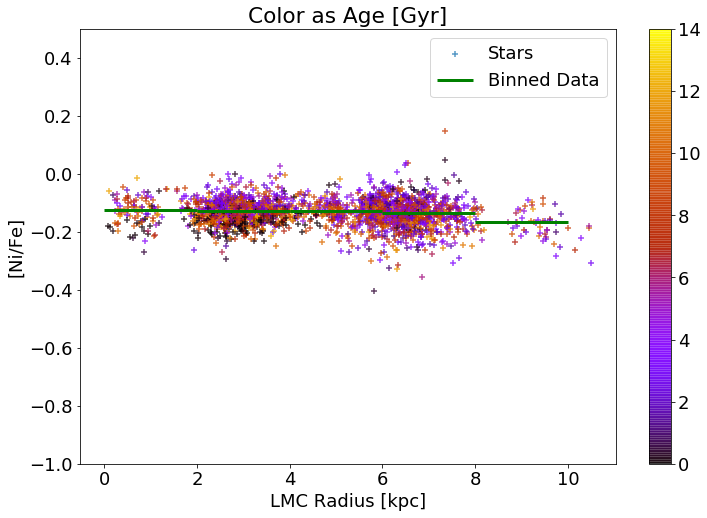

In [380]:
plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],dr16snr['NI_FE'][y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],dr16snr['NI_FE'][y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.5)
#plt.xscale('log')
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_ni.jpg',bbox_inches='tight')
plt.show()

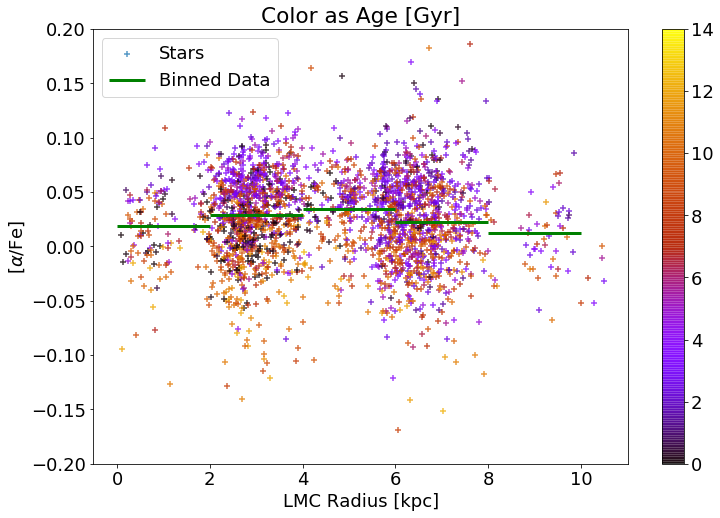

In [382]:
plt.figure(figsize=[12,8])
plt.scatter(dr16snr[y_ind]['LMCRAD'],(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'])[y_ind],marker='+',c=10**clnpdfout['P_MEAN'][x_ind]/10**9,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
bin_means, bin_edges, binnumber = st.binned_statistic(dr16snr[y_ind]['LMCRAD'],(dr16snr['ALPHA_M']+dr16snr['M_H']-dr16snr['FE_H'])[y_ind],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Binned Data')
#plt.plot(chrisage/10**9,Chrismod['CoFe'],c='k',label='Evolution Model')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.2,0.2)
#plt.xscale('log')
plt.title(r'Color as Age [Gyr]')
plt.colorbar()
plt.legend()
plt.savefig('dparsec_age_alpha.jpg',bbox_inches='tight')
plt.show()

In [390]:
alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)

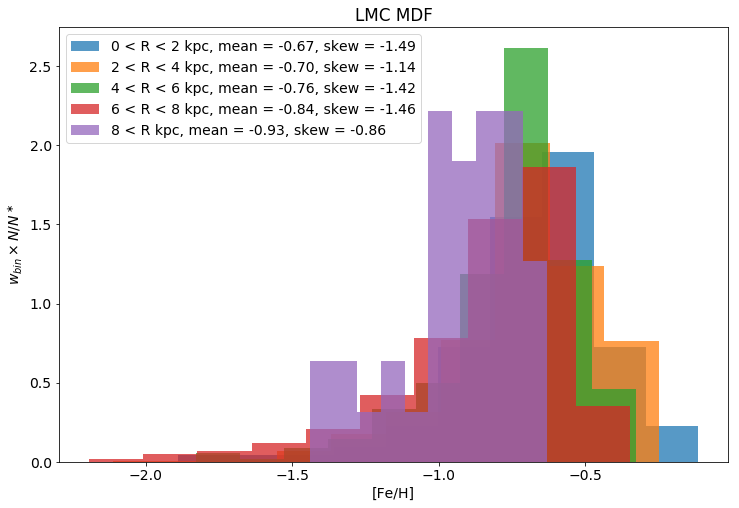

In [57]:
from scipy.stats import skew
rad02 = np.where(dr16snr['LMCRAD']<2.0) 
rad24 = np.where((dr16snr['LMCRAD']>2.0)&(dr16snr['LMCRAD']<4.0))
rad46 = np.where((dr16snr['LMCRAD']>4.0)&(dr16snr['LMCRAD']<6.0))
rad68 = np.where((dr16snr['LMCRAD']>6.0)&(dr16snr['LMCRAD']<8.0))
rad8p = np.where(dr16snr['LMCRAD']>8.0)

radbins = [rad02,rad24,rad46,rad68,rad8p]
means = []
skews = []
for i in radbins:
    means.append(np.mean(dr16snr['FE_H'][i]))
    skews.append(skew(dr16snr['FE_H'][i]))
    
means = np.around(means,decimals=2)
skews = np.around(skews,decimals=2)
# print(skews)

plt.figure(figsize=[12,8])
plt.hist(dr16snr['FE_H'][rad02],density=1.0,alpha=0.75,stacked=True,\
         label='0 < R < 2 kpc, mean = -0.67, skew = {}'.format(skews[0]))
plt.hist(dr16snr['FE_H'][rad24],density=1.0,alpha=0.75,stacked=True,\
         label='2 < R < 4 kpc, mean = -0.70, skew = {}'.format(skews[1]))
plt.hist(dr16snr['FE_H'][rad46],density=1.0,alpha=0.75,stacked=True,\
         label='4 < R < 6 kpc, mean = -0.76, skew = {}'.format(skews[2]))
plt.hist(dr16snr['FE_H'][rad68],density=1.0,alpha=0.75,stacked=True,\
         label='6 < R < 8 kpc, mean = -0.84, skew = {}'.format(skews[3]))
plt.hist(dr16snr['FE_H'][rad8p],density=1.0,alpha=0.75,stacked=True,\
         label='8 < R kpc, mean = -0.93, skew = {}'.format(skews[4]))
plt.legend(loc='upper left')
plt.ylabel(r'$w_{bin} \times N/N^\ast}$')
plt.xlabel(r'[Fe/H]')
plt.title(r'LMC MDF')
plt.show()

In [47]:
dr16snr.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name

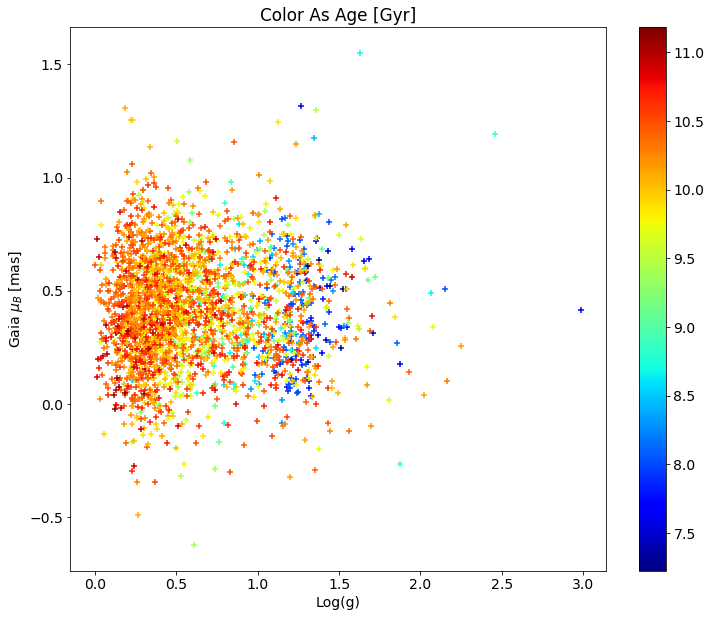

In [16]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LOGG'],clndr16['GAIA_PMMB'],marker='+',c=testparage,cmap='jet')
plt.xlabel('Log(g)')
plt.ylabel('Gaia $\mu_{B}$ [mas]')
plt.colorbar()
plt.title(r'Color As Age [Gyr]')
#plt.savefig('salaris_CN.pdf',bbox_inches='tight')
plt.show()

In [18]:
10**11/10**9

100.0

In [19]:
devs

NameError: name 'devs' is not defined